# Project 1: Gradient-based Algorithms and Differentiable Programming

##### Consider a simple formulation of Dart throwing model and aiming for the bull's eye where the dart state X(t) is represented by its coordinates x(t) and y(t), velocity v_x(t) and v_y(t), orientation θ(t) i.e. X(t)=[x(t),y(t),v_x(t),v_y(t),θ(t)]^T where t specifies time. The control input u(t) of the dart includes force force and angular velocity ω(t). The constants considered here are mass of the dart i.e. DART_MASS=23, Δt i.e. FRAME_TIME=0.1, GRAVITY_ACCEL_Y=9.8. The discrete-time dynamics follows:

#### x(t+1)=x(t)+v_x(t)Δt
#### y(t+1)=y(t)+v_y(t)Δt-0.5gΔt^2
#### V_x(t+1)=v_x(t)+(force/mass(cos(θ)Δt))
#### V_y(t+1)=v_x(t)+(((force/mass(sin(θ))-g)Δt)
#### θ(t+1)=θ(t)+ω(t)Δt

####  The closed-loop controller be u(t)=[force+ω(t)]=πw(X(t))
#### where πw(⋅) is a neural network with parameters w, which are to be determined through optimization.
#### The optimization problem is now formulated as min w ||X(t)||^2

In [32]:


# overhead
import logging
import math
import random
import numpy as np
import time
import torch 
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

In [33]:
# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 9.8  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.  # gravity constant in X direction 
OMEGA_RATE = 0.1  # max rotation rate
DART_MASS = 23

#### Here we set up the dynamical model in Pytorch. The dynamics is written as the forward pass of a neural network (nn.Module) so that it becomes a part of a differentiable computational graph. 
#### Some explanation:

#### delta_state_gravity is a vector 
[0,0,0,−gΔt,0]

#### state_tensor is 
[0,0,cos(θ),sin(θ),0]

#### delta_state_theta is 
[0,0,0,0,ω(t)∗Δt∗omega rate]

#### the state of t+1 is denoted by state and its first two elements (x and y coordinates) are updated by


#### the velocity and orientation are then updated by state = state + delta_state  + delta_state_gravity + delta_state_theta

In [34]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Force
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta
      
        """

        delta_state_gravity = torch.tensor([[0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 2] = torch.cos(state[0, 4])
        state_tensor[0, 3] = torch.sin(state[0, 4])
        
        delta_state = 1/DART_MASS * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1)) 

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])
        
        shift_mat = torch.tensor([[0., 0.,0., 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) +  torch.matmul(shift_mat, delta_state_gravity.T)  * 0.5
        state = state.T

        state = state + delta_state  + delta_state_gravity + delta_state_theta

        return state

In [35]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: 
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

In [51]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[0.,0.,1.17,9.93,75]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean((state) ** 2)

In [52]:
class Optimize:
    
    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects
    
    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.001) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function
    
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model
    

    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()
            
        plt.plot(list(range(epochs)), l)
            
        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        
    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

[1] loss: 33373.012


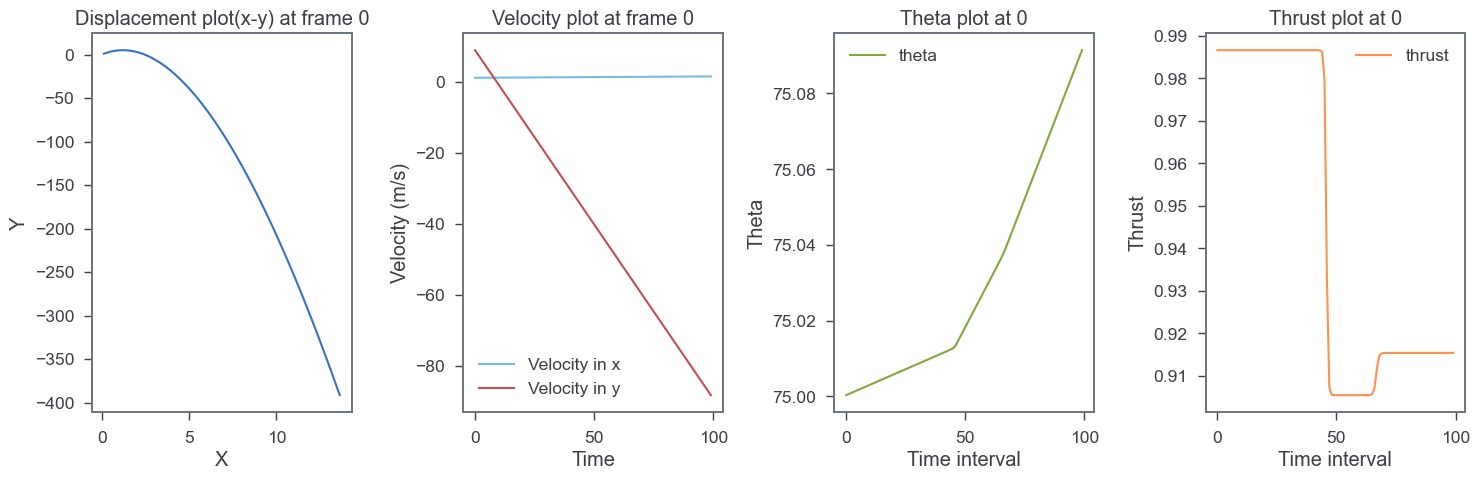

[2] loss: 33345.695


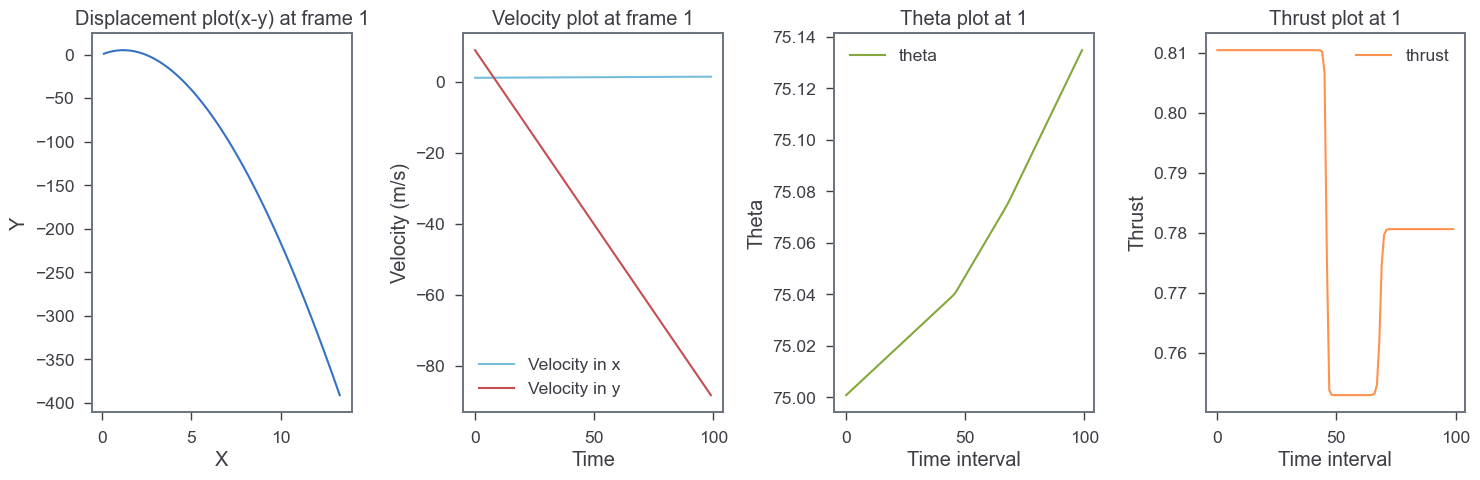

[3] loss: 33328.992


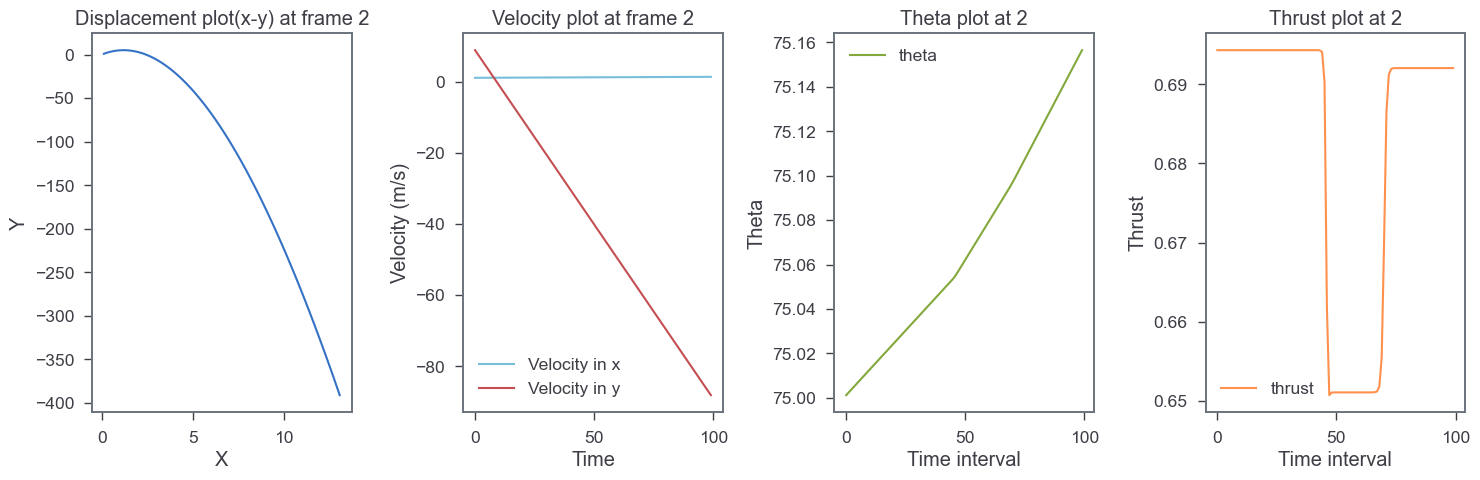

[4] loss: 33314.930


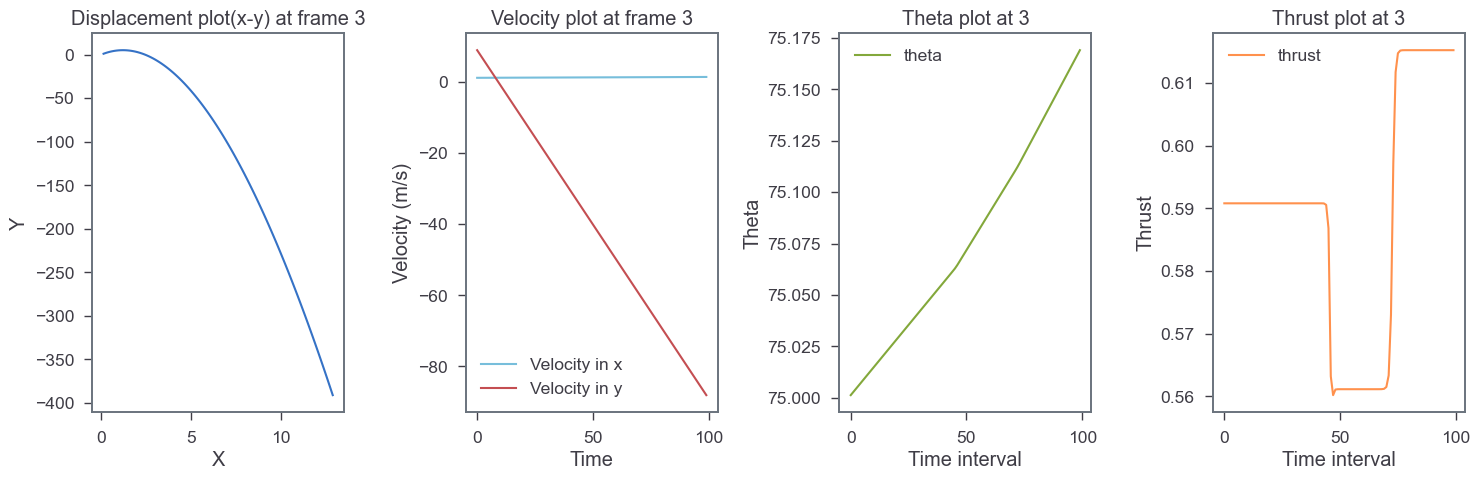

[5] loss: 33304.812


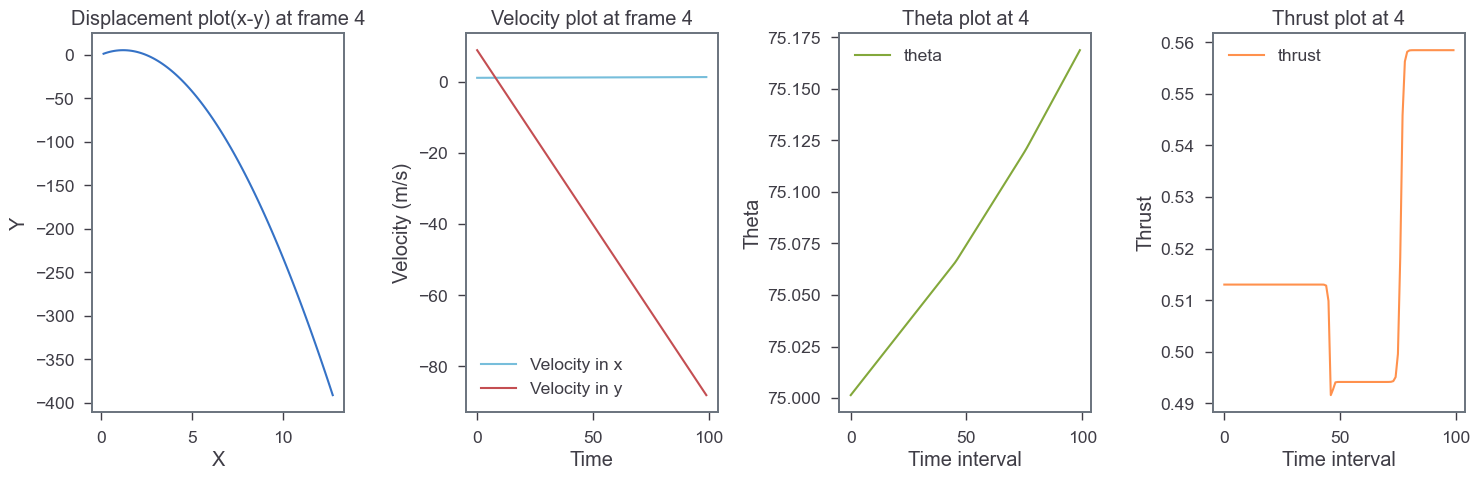

[6] loss: 33295.000


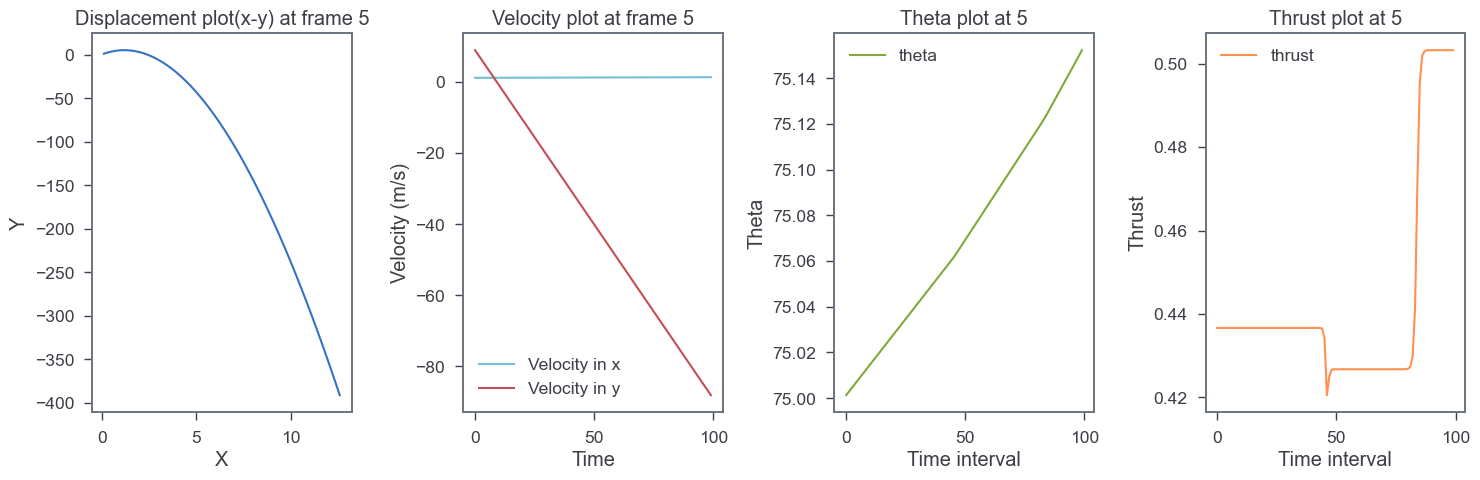

[7] loss: 33286.211


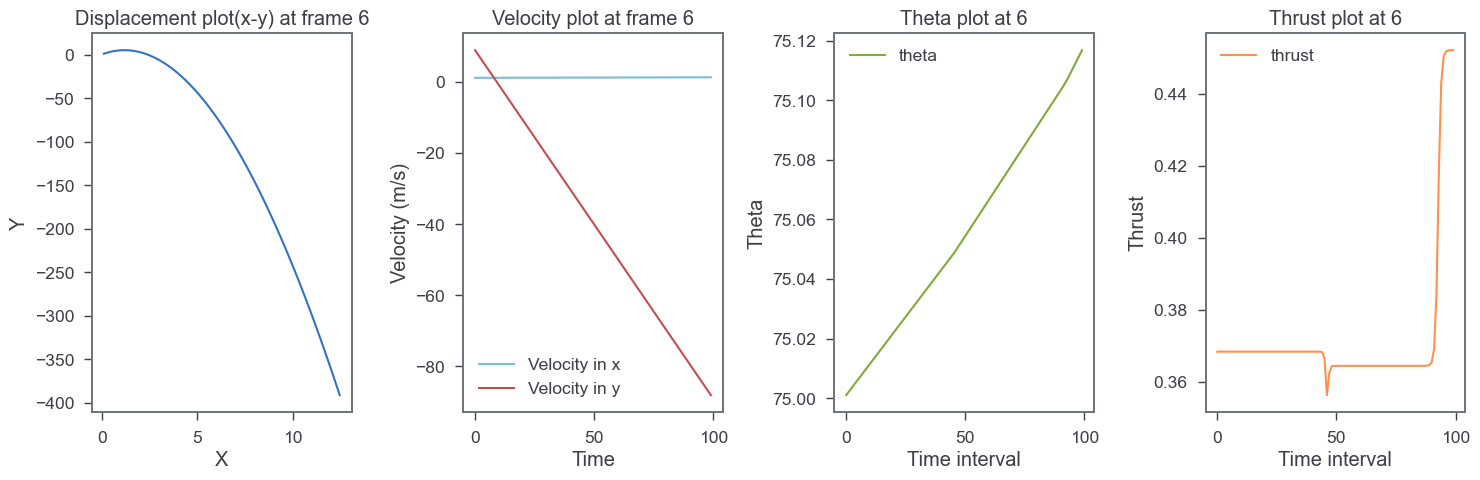

[8] loss: 33276.566


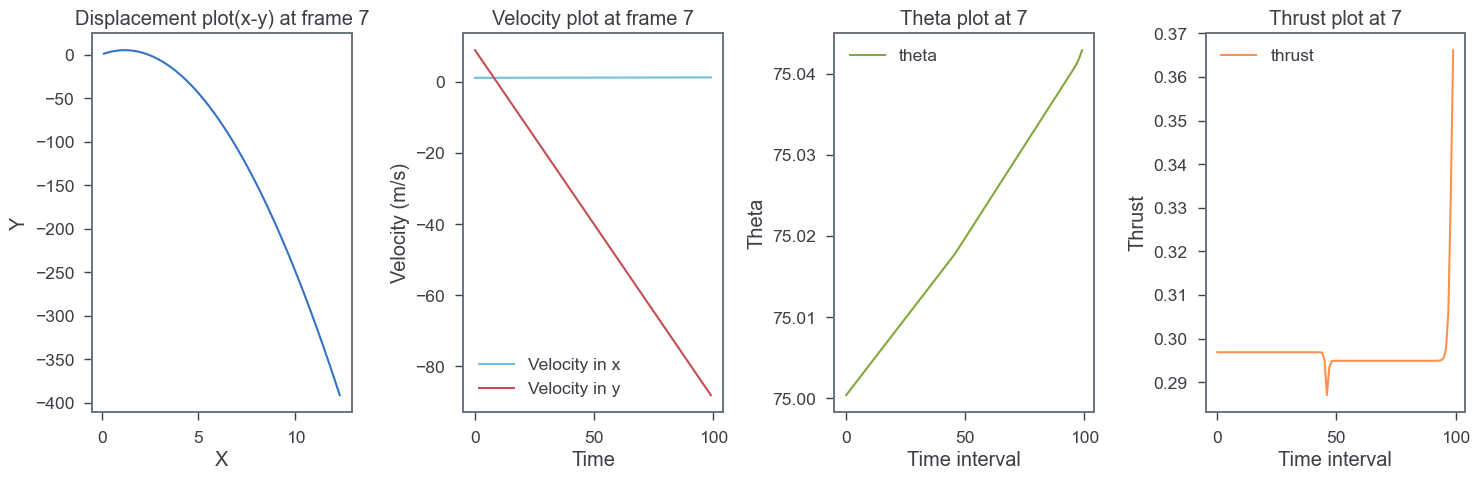

[9] loss: 33263.301


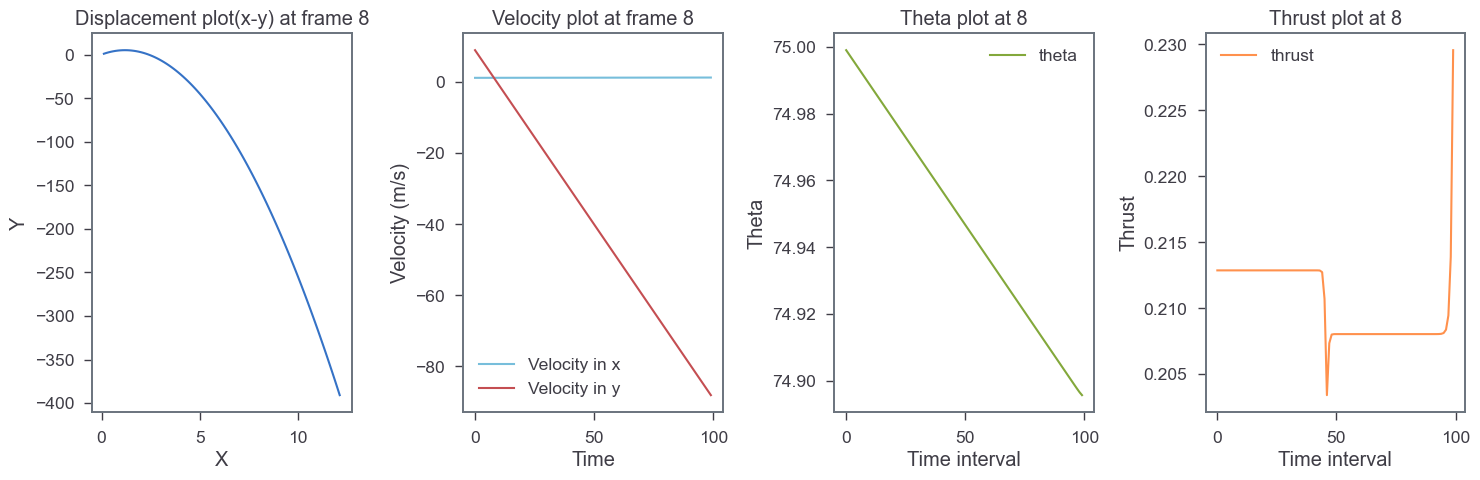

[10] loss: 33255.359


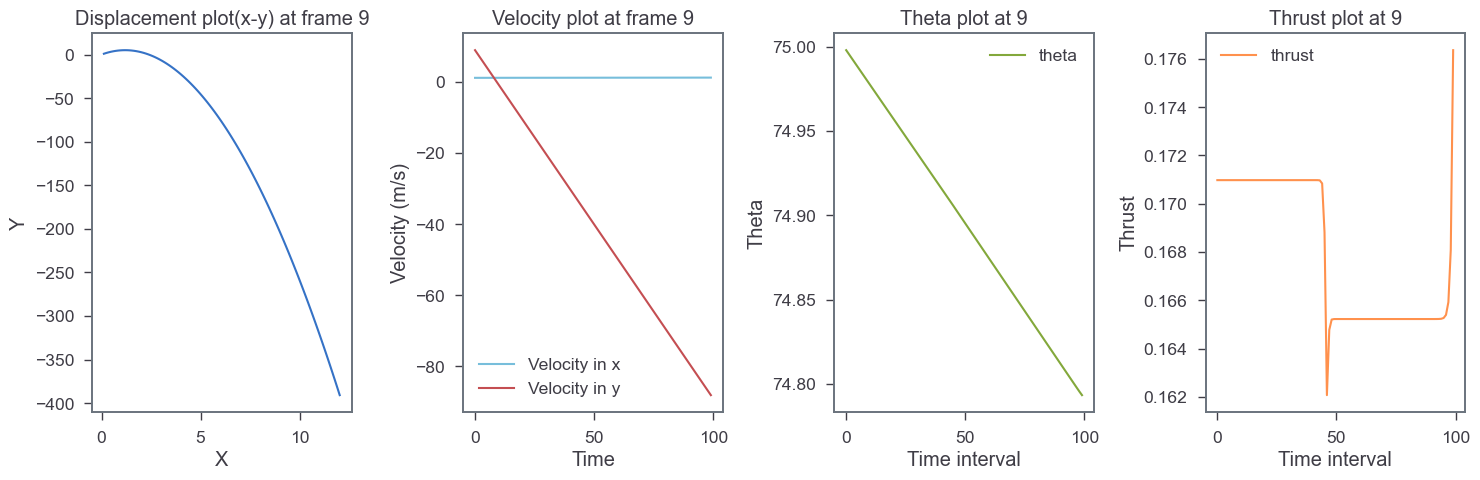

[11] loss: 33249.590


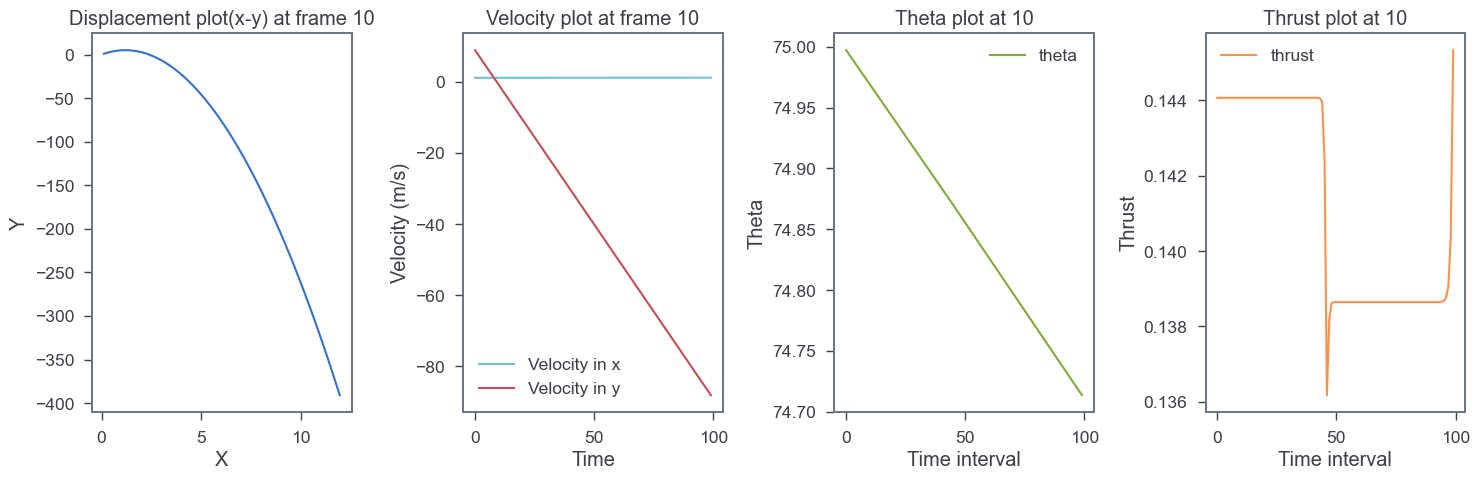

[12] loss: 33244.977


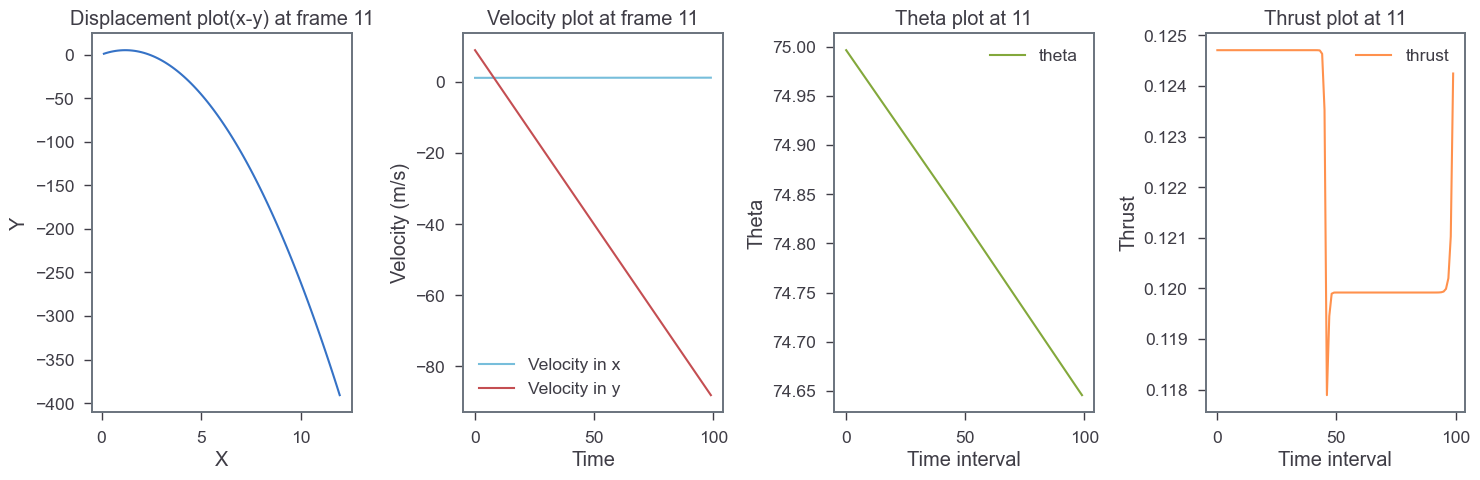

[13] loss: 33240.715


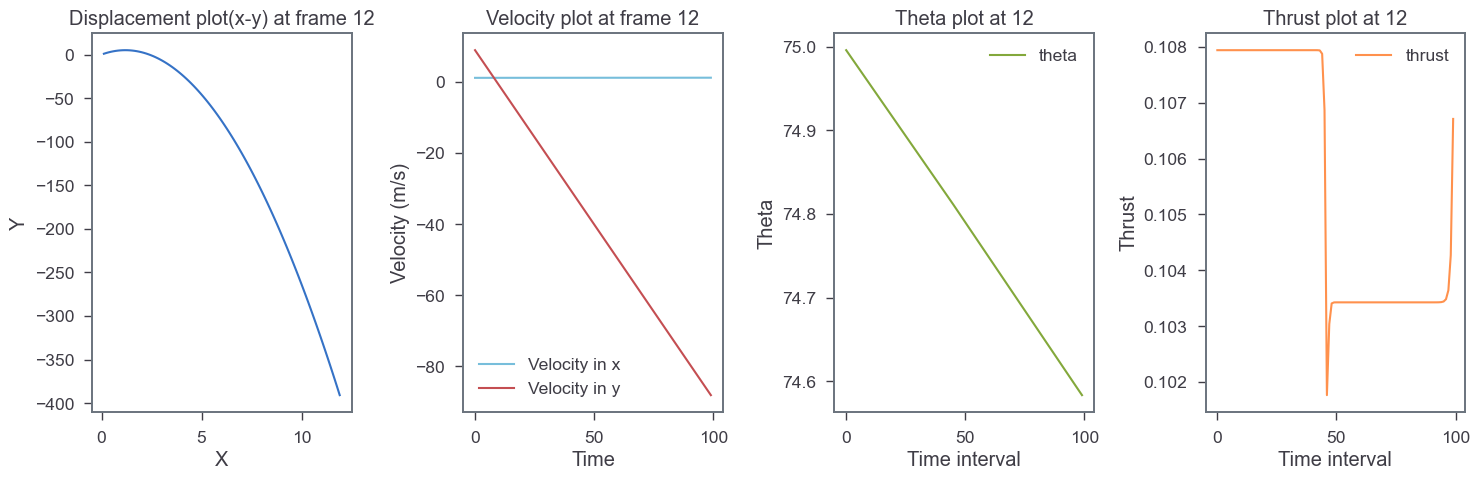

[14] loss: 33237.320


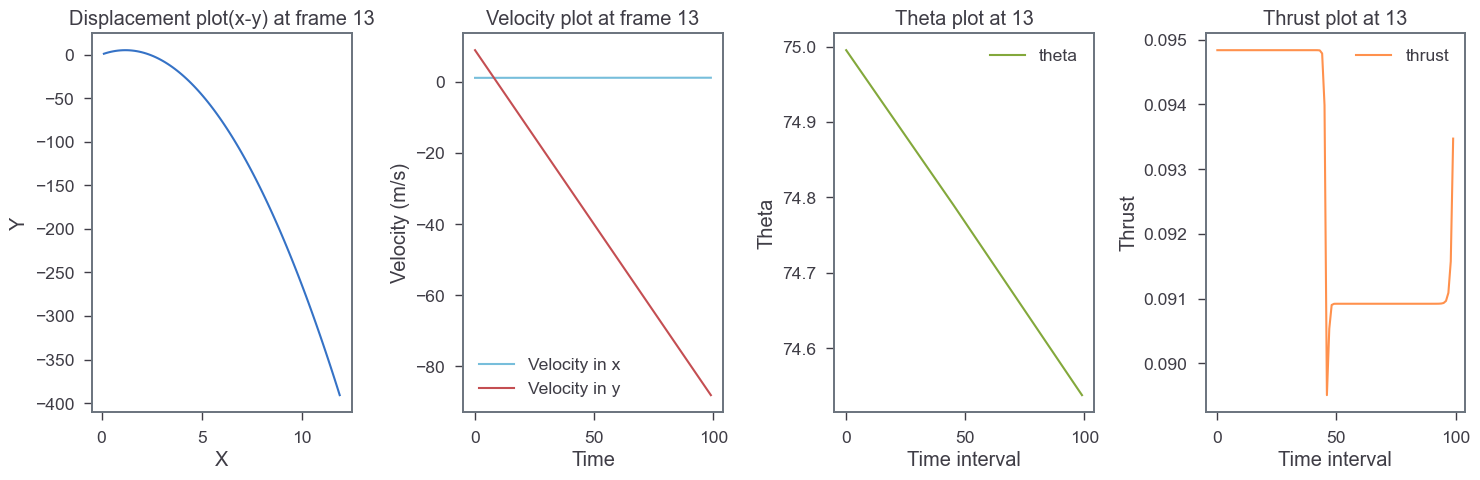

[15] loss: 33234.574


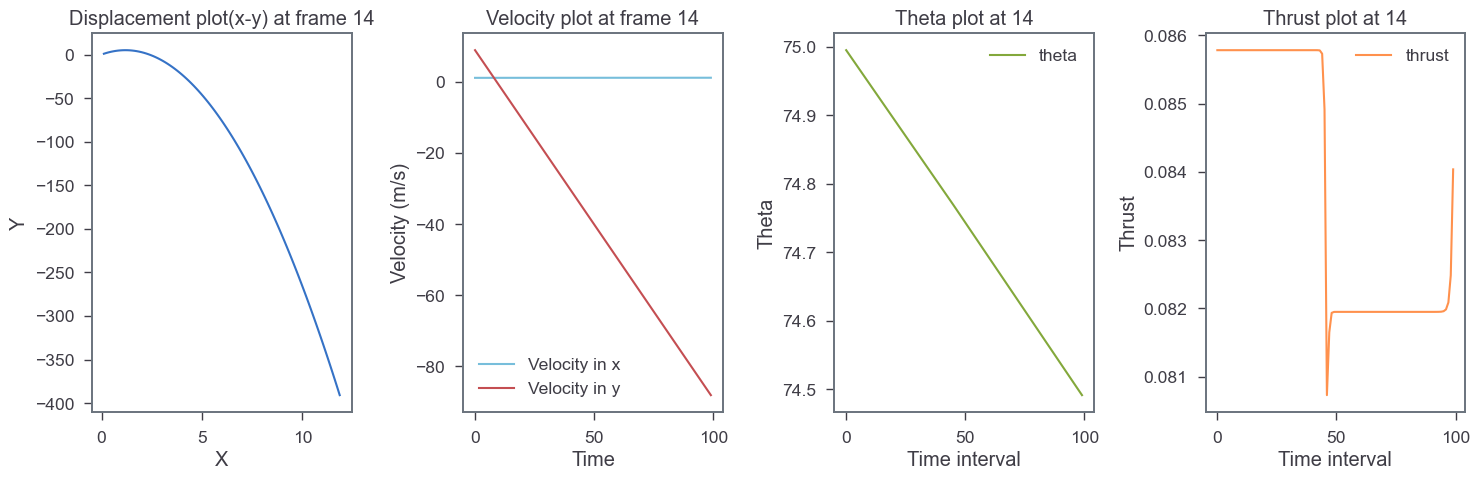

[16] loss: 33231.227


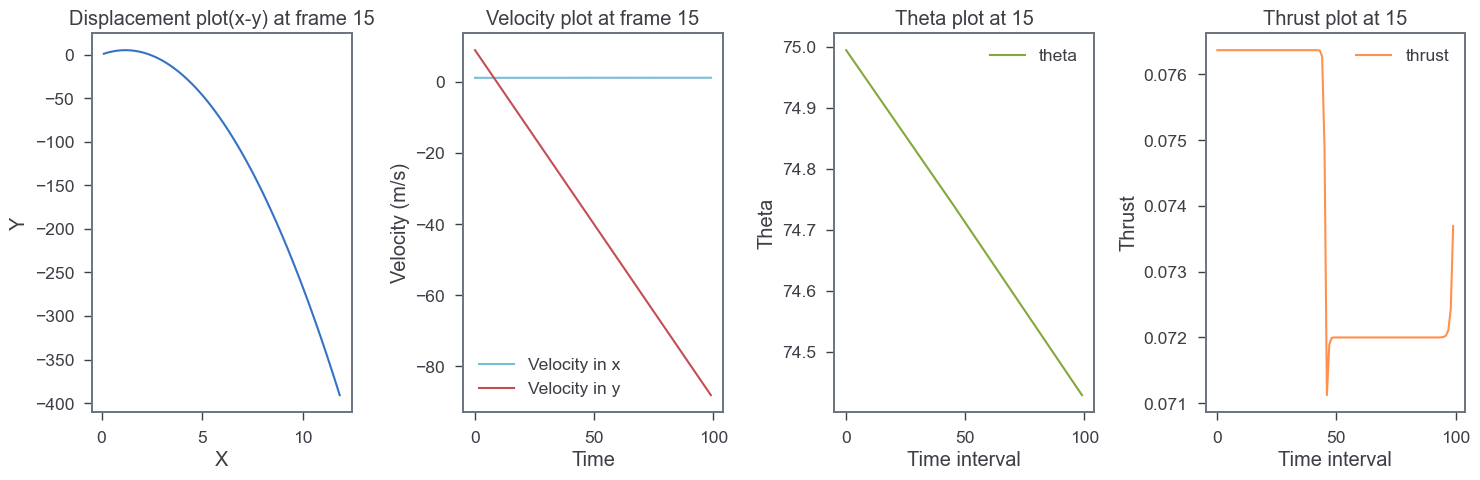

[17] loss: 33226.996


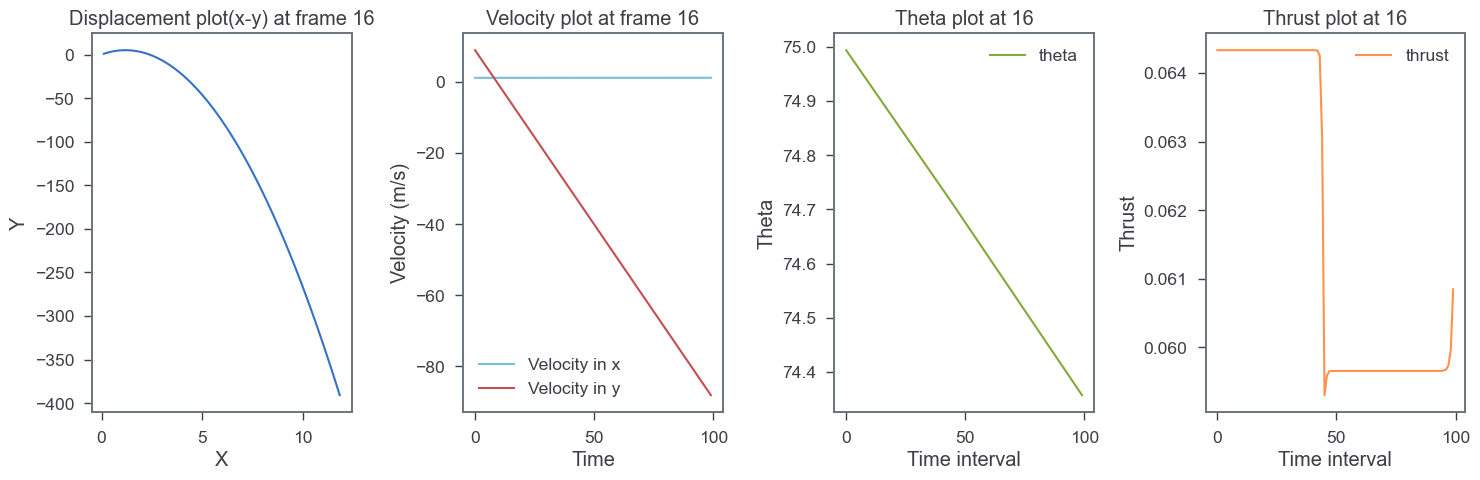

[18] loss: 33222.570


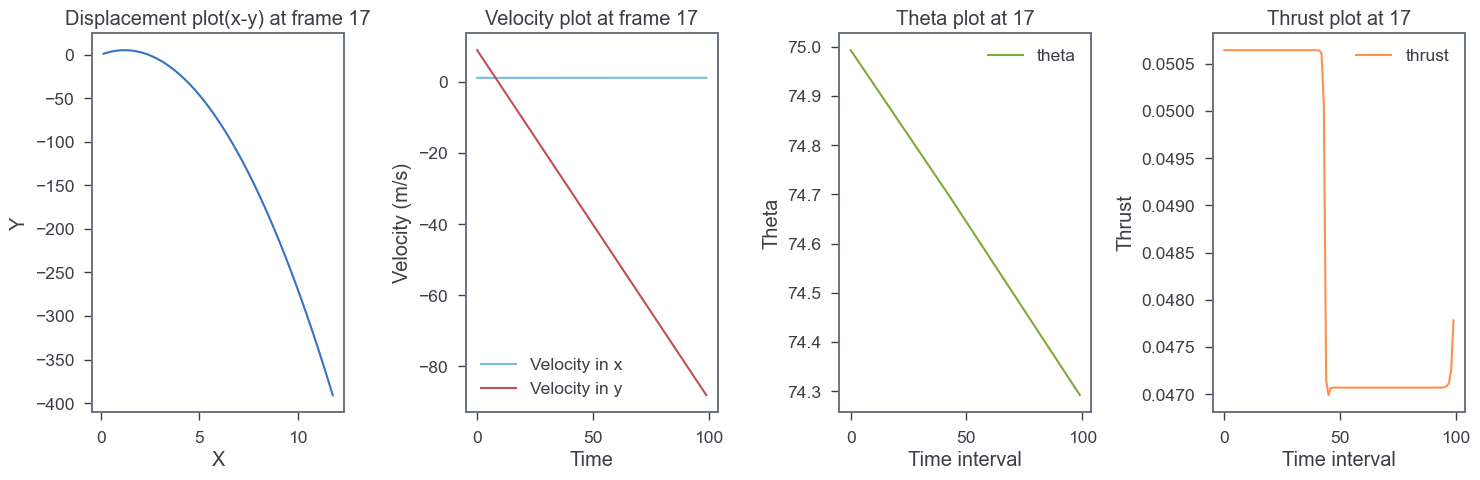

[19] loss: 33219.695


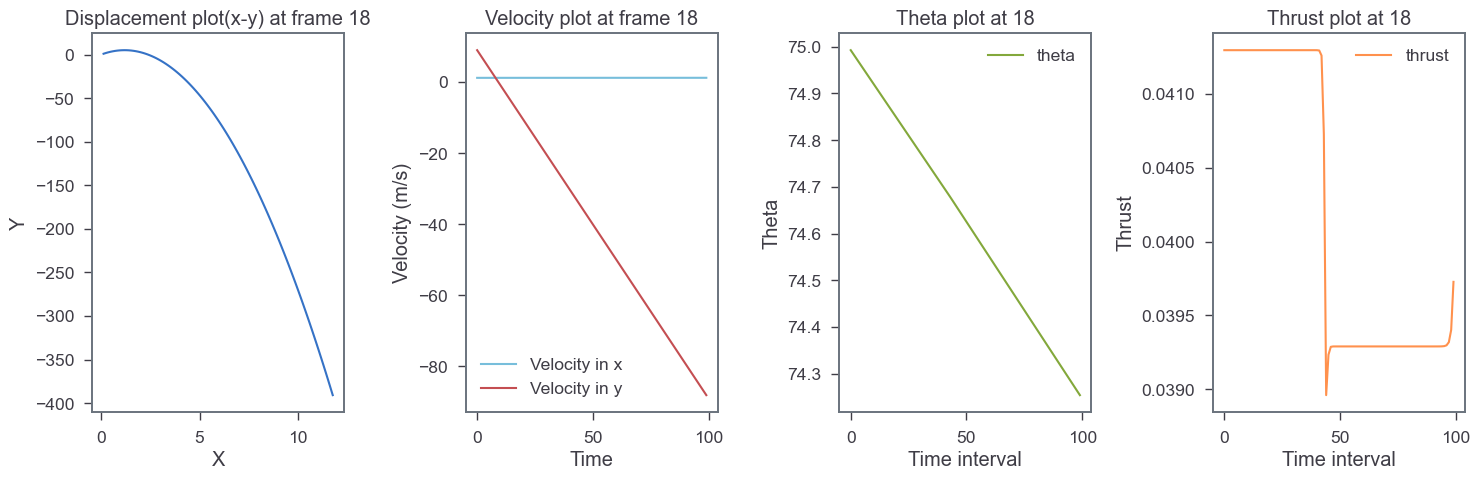

[20] loss: 33217.891


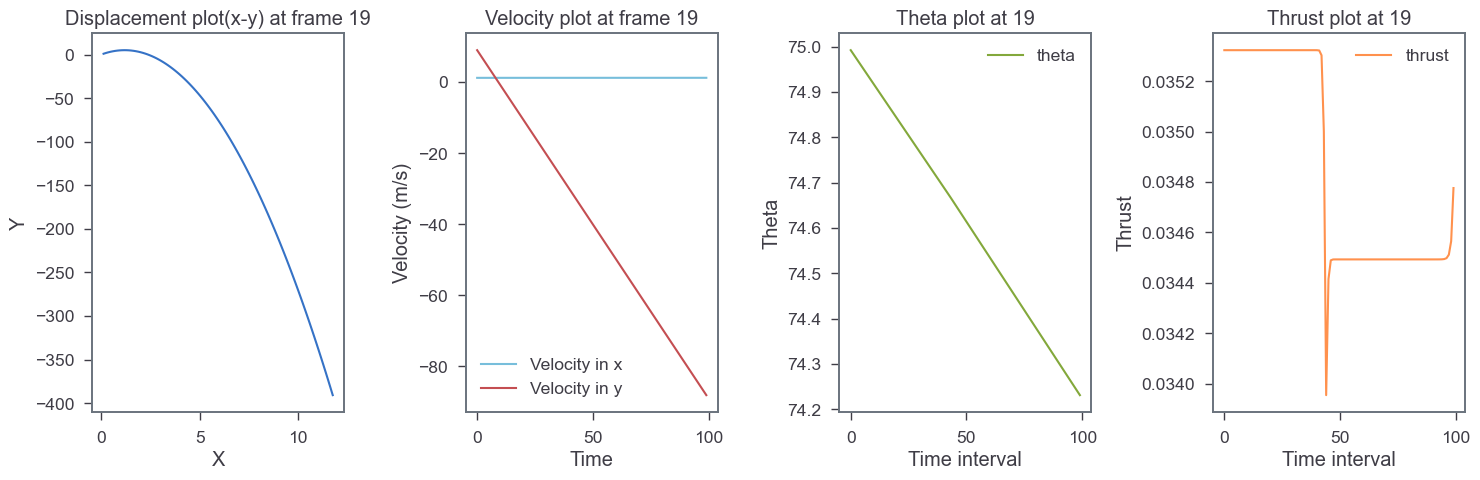

[21] loss: 33216.598


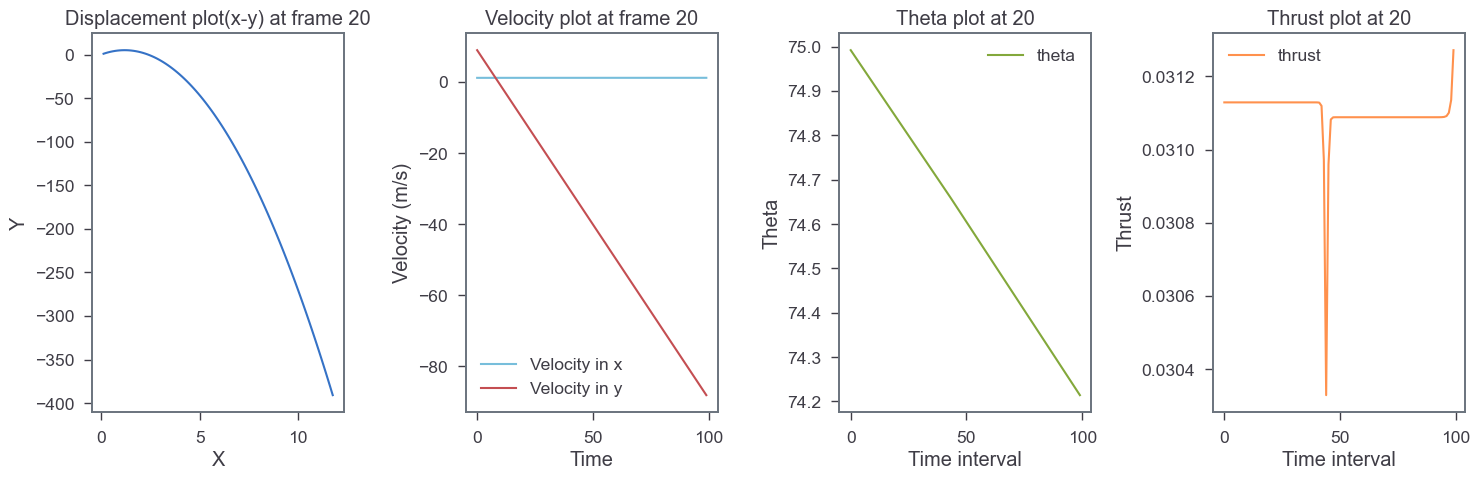

[22] loss: 33215.500


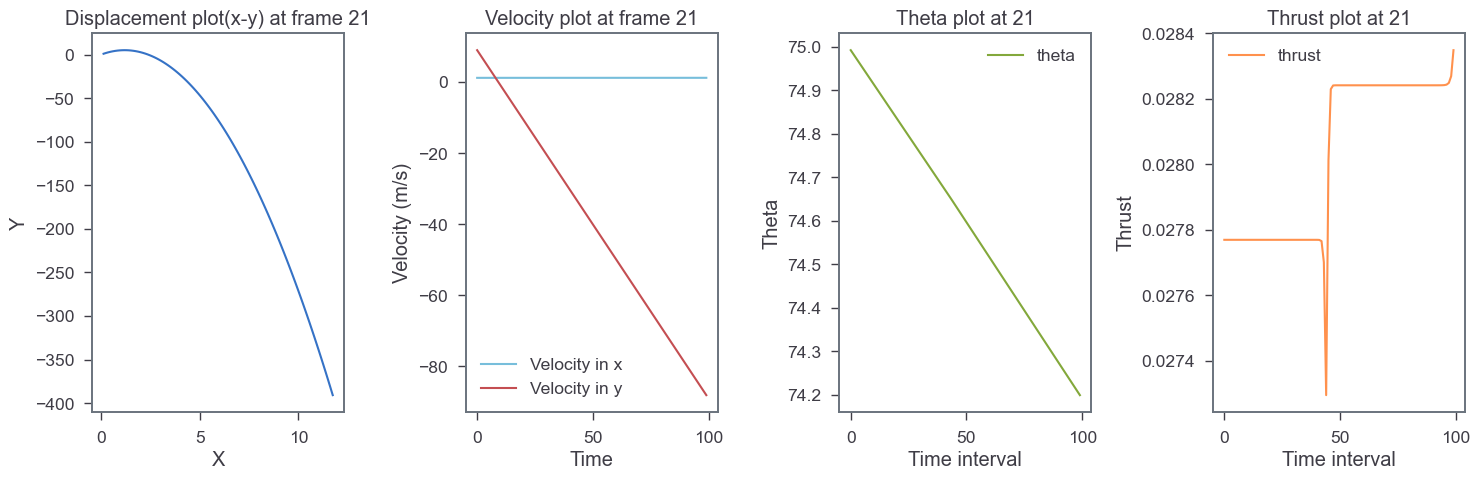

[23] loss: 33214.445


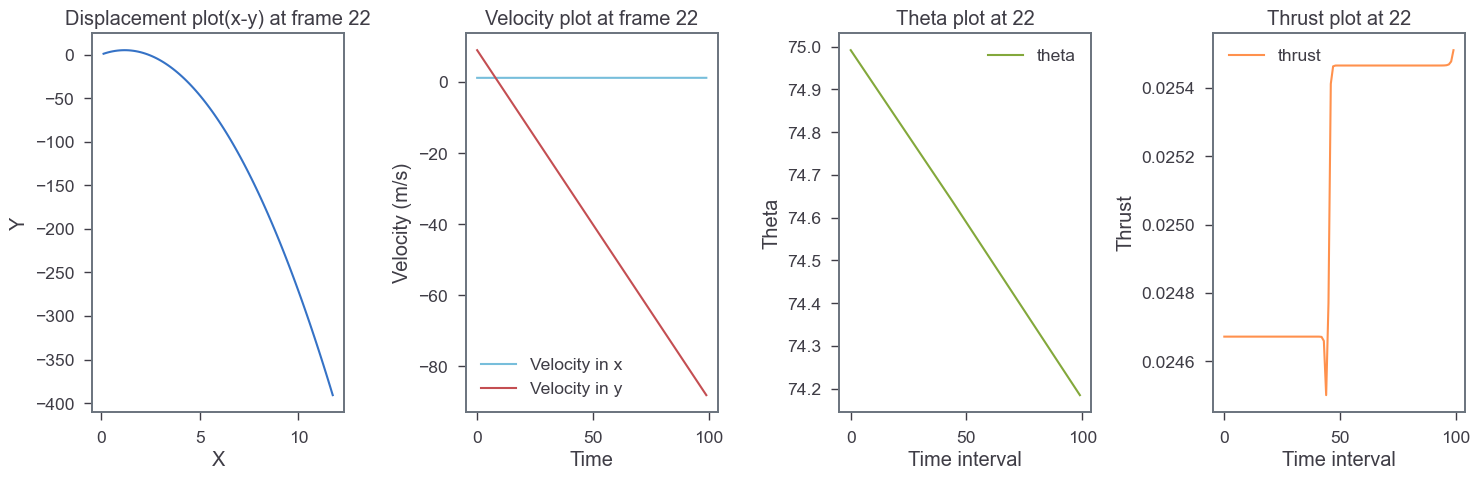

[24] loss: 33213.449


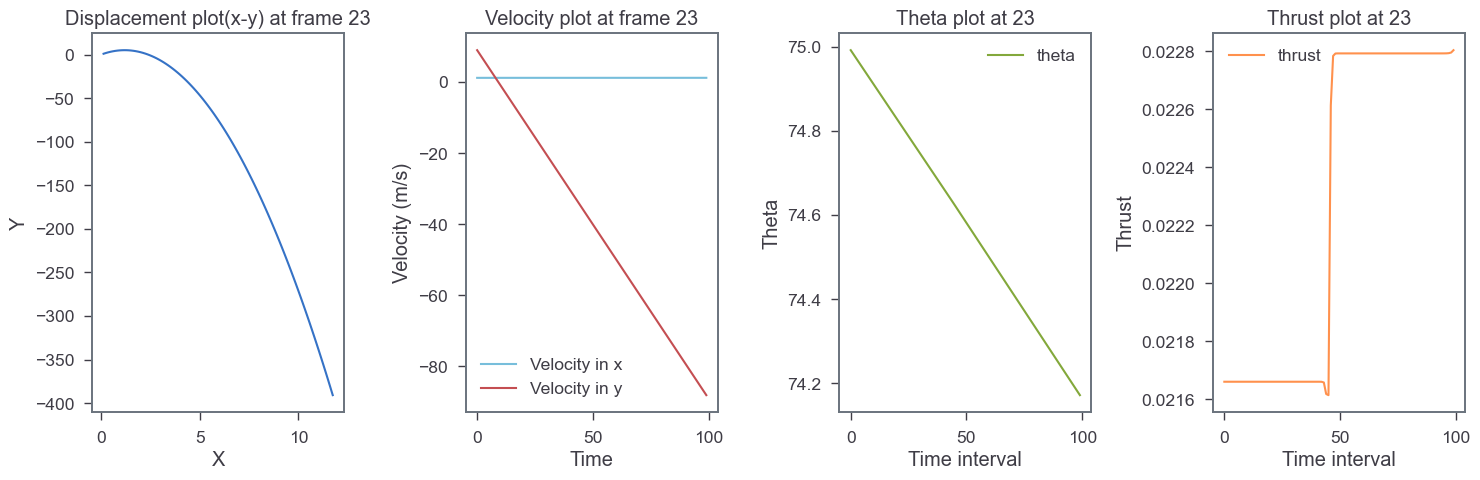

[25] loss: 33212.574


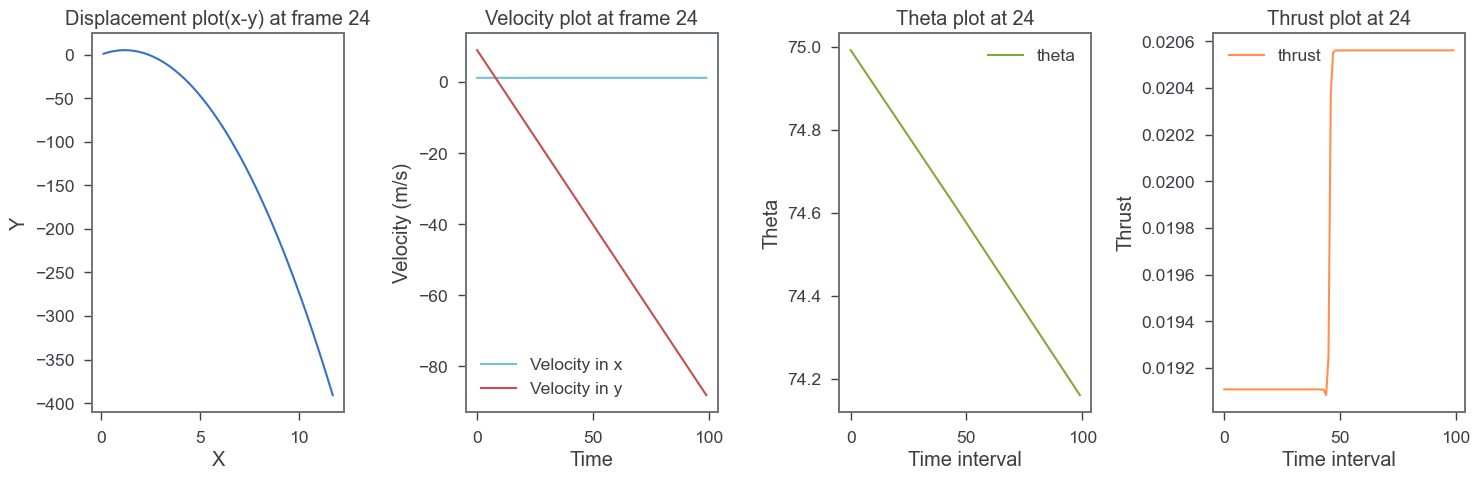

[26] loss: 33211.871


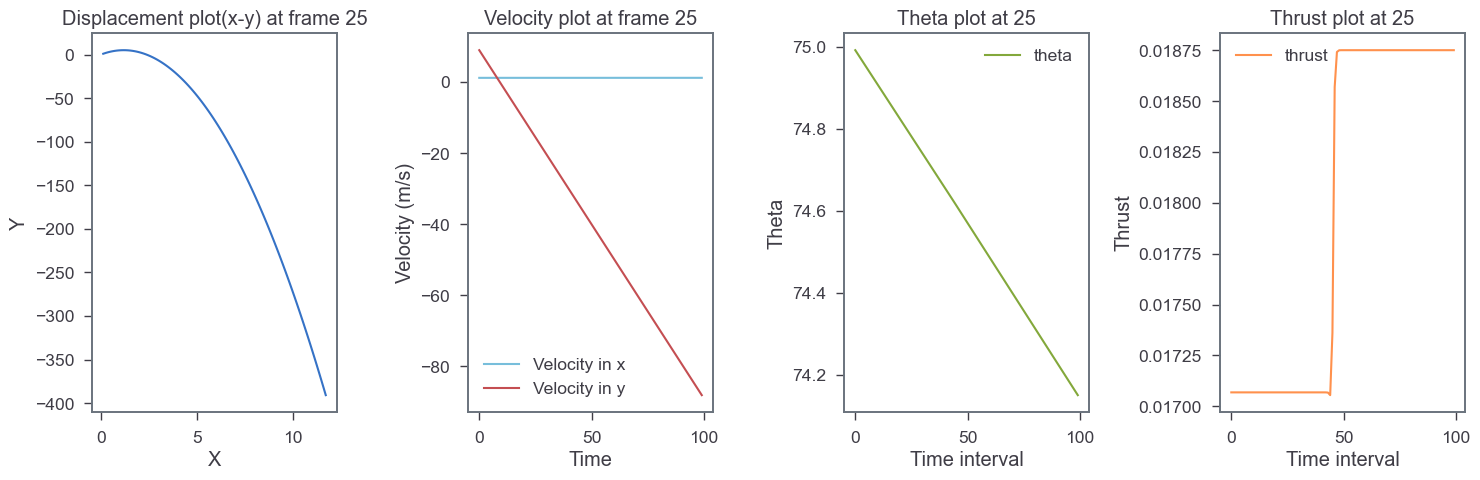

[27] loss: 33211.039


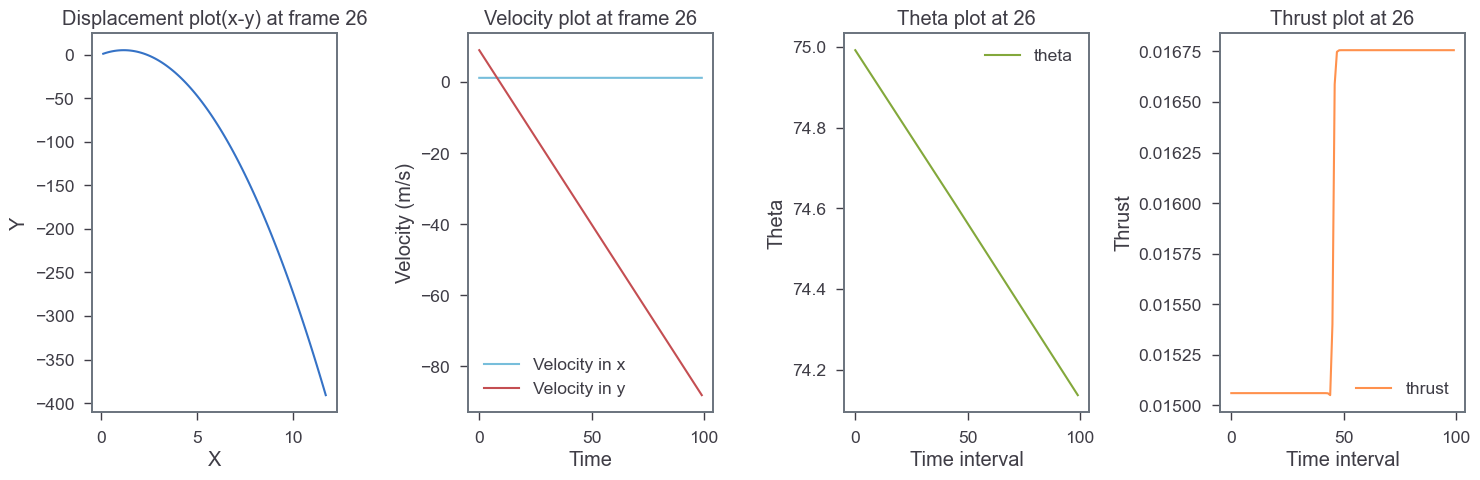

[28] loss: 33210.320


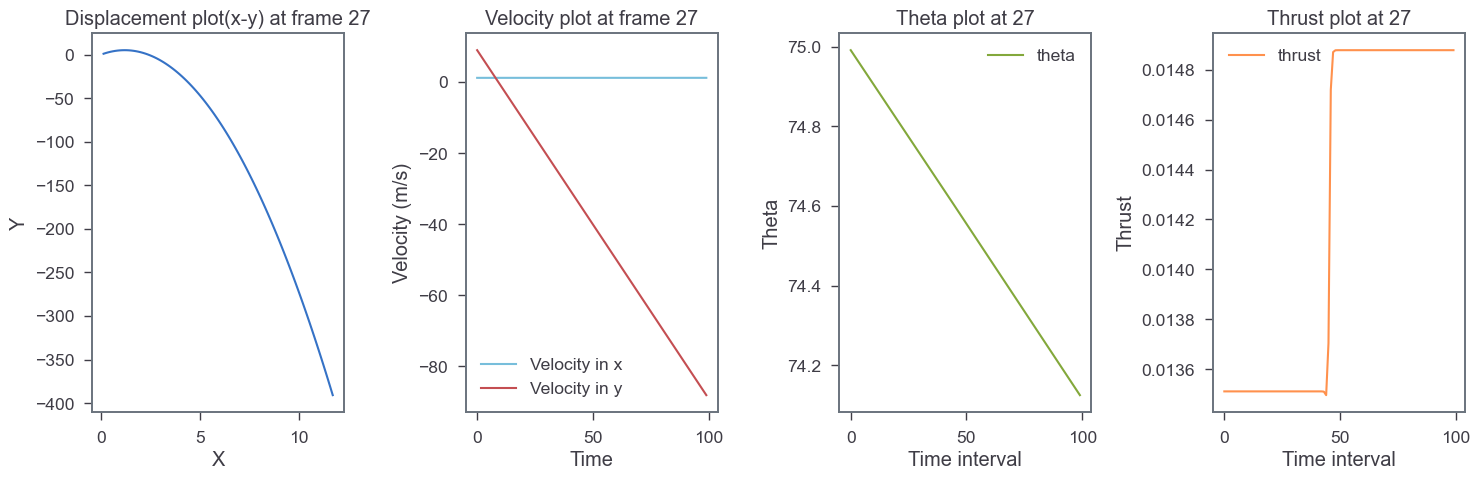

[29] loss: 33209.789


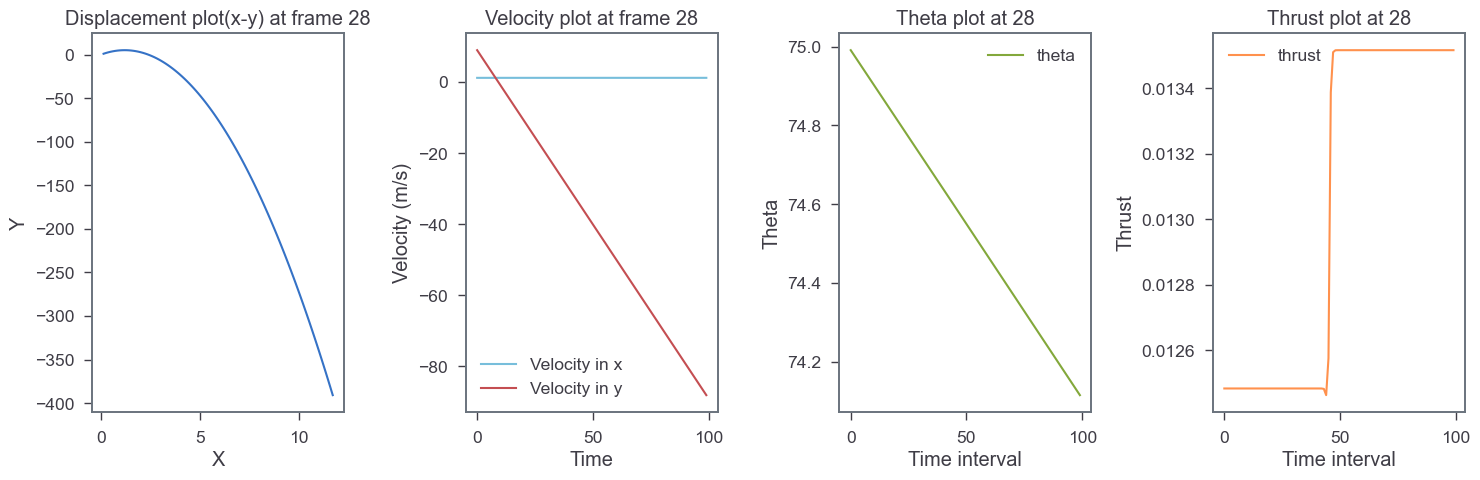

[30] loss: 33207.754


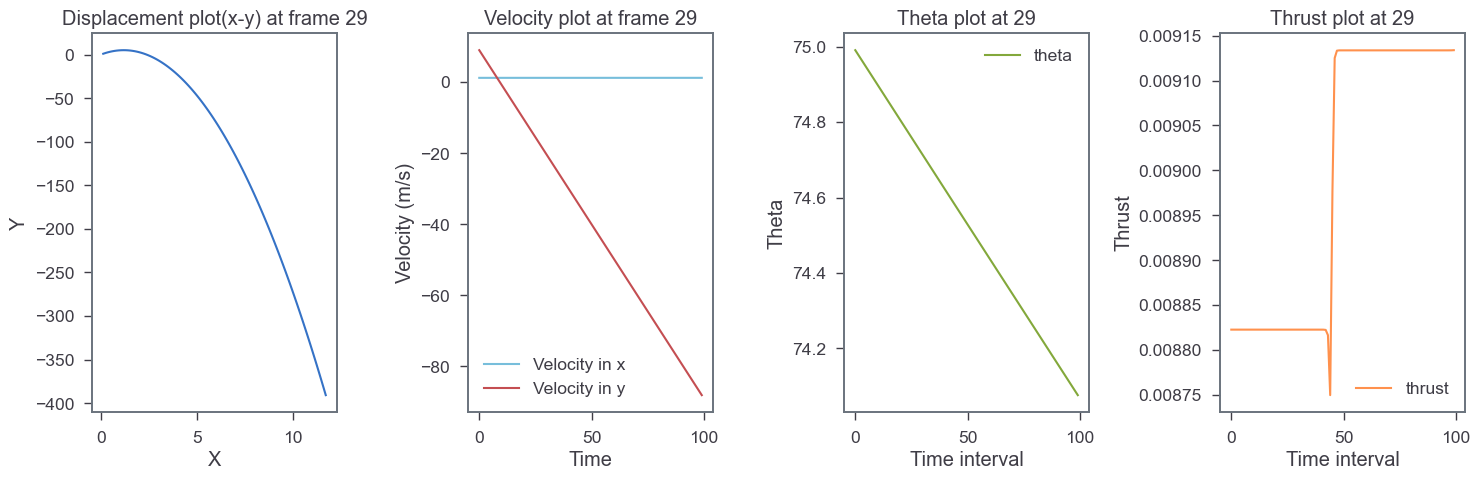

[31] loss: 33206.328


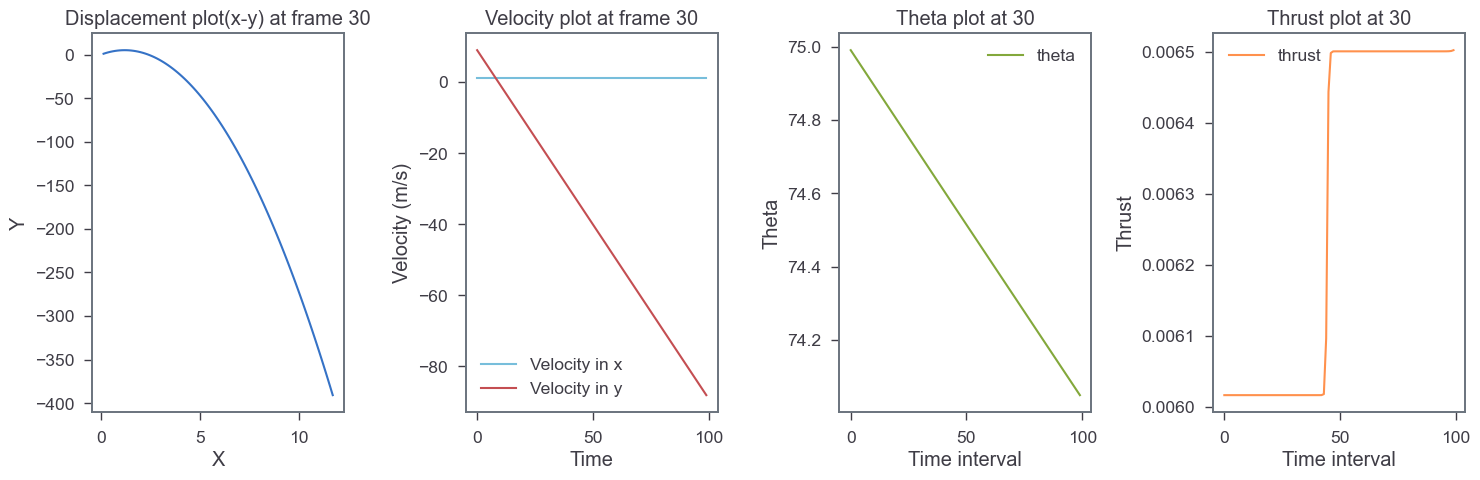

[32] loss: 33205.914


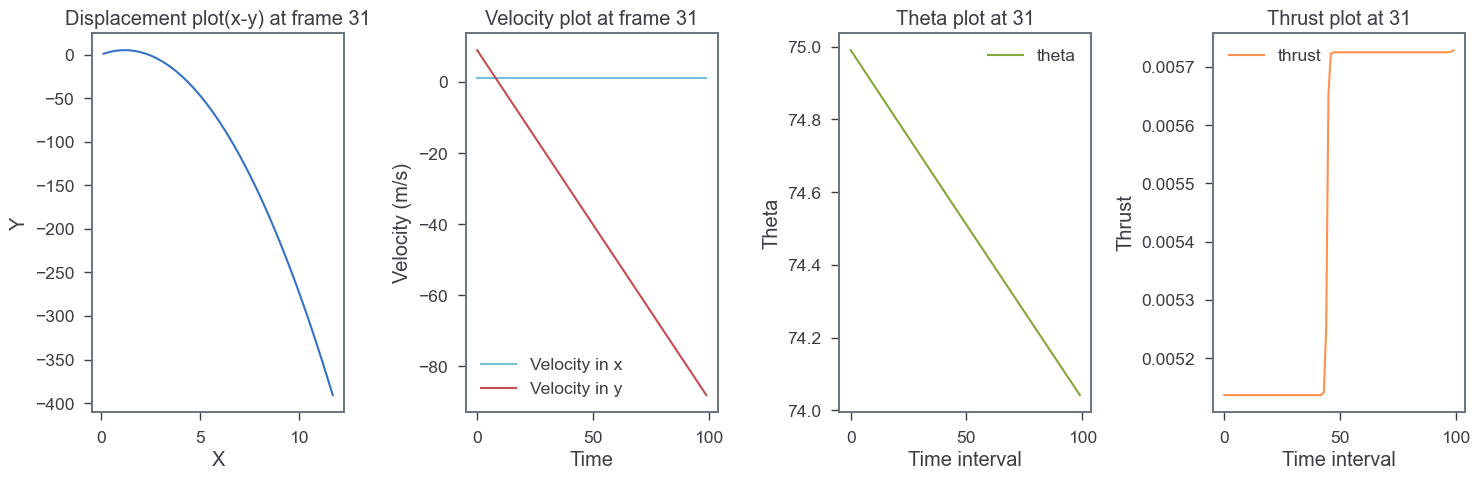

[33] loss: 33205.895


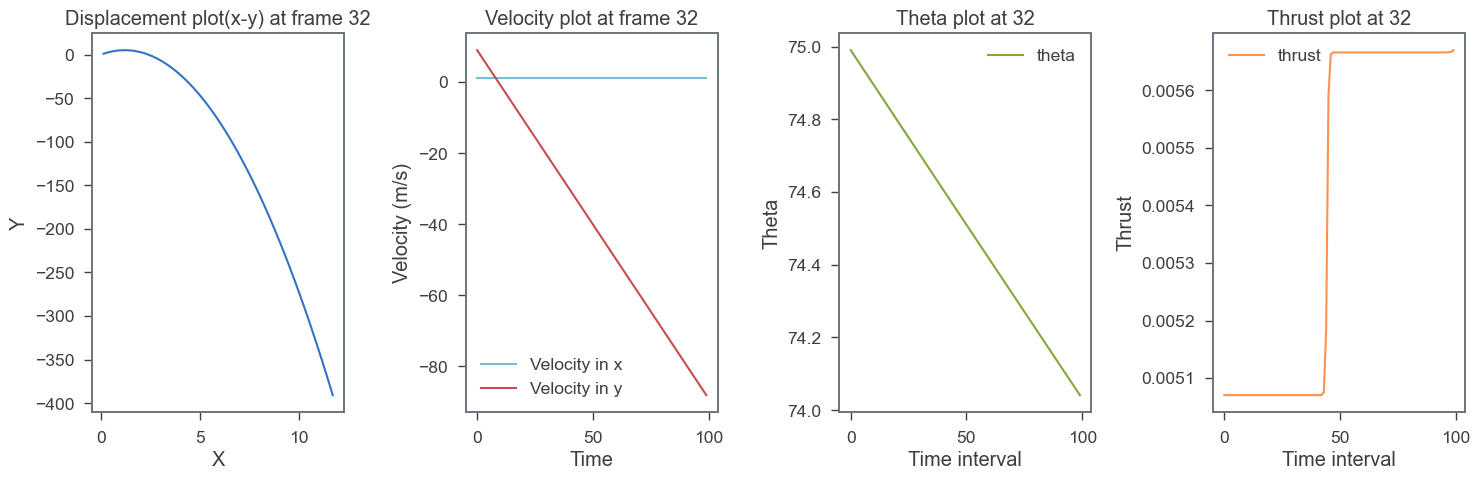

[34] loss: 33205.828


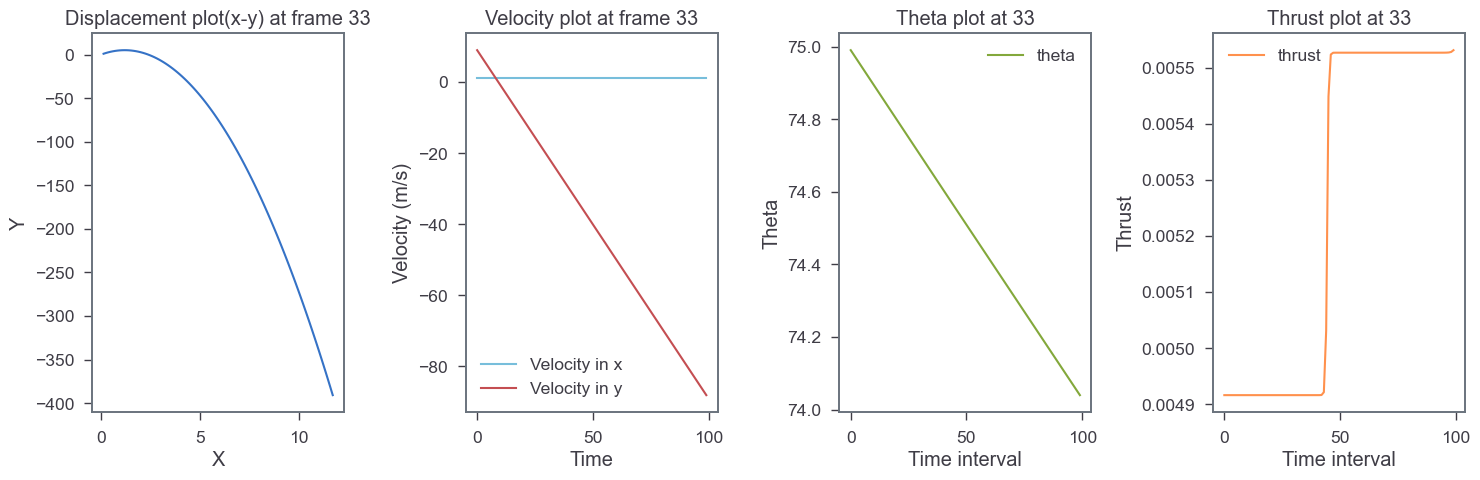

[35] loss: 33205.742


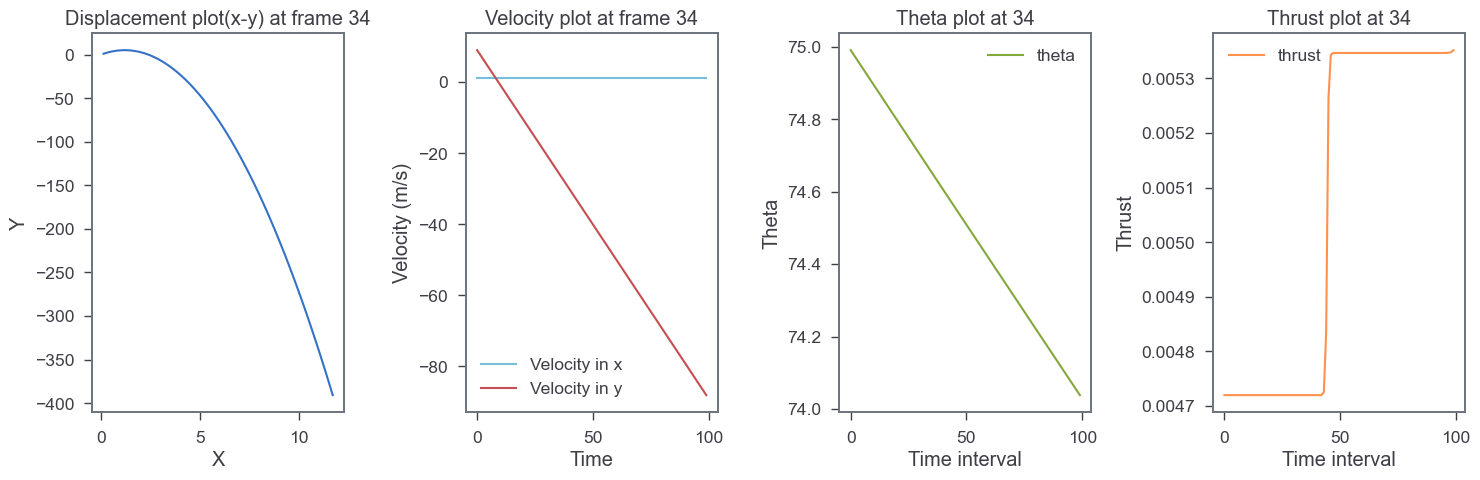

[36] loss: 33205.574


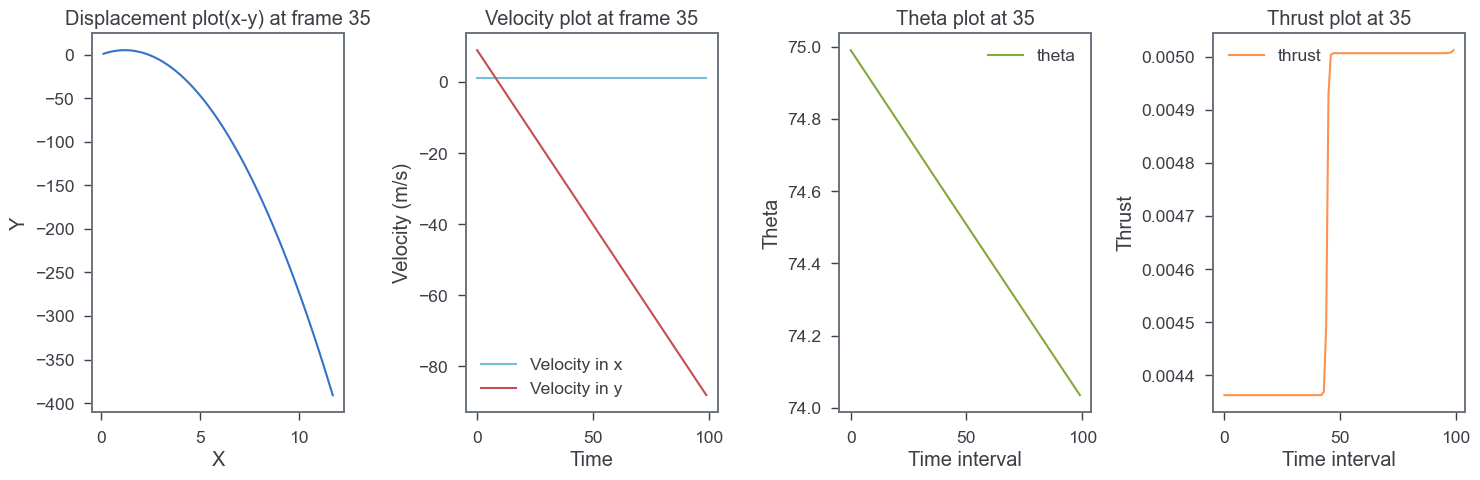

[37] loss: 33205.539


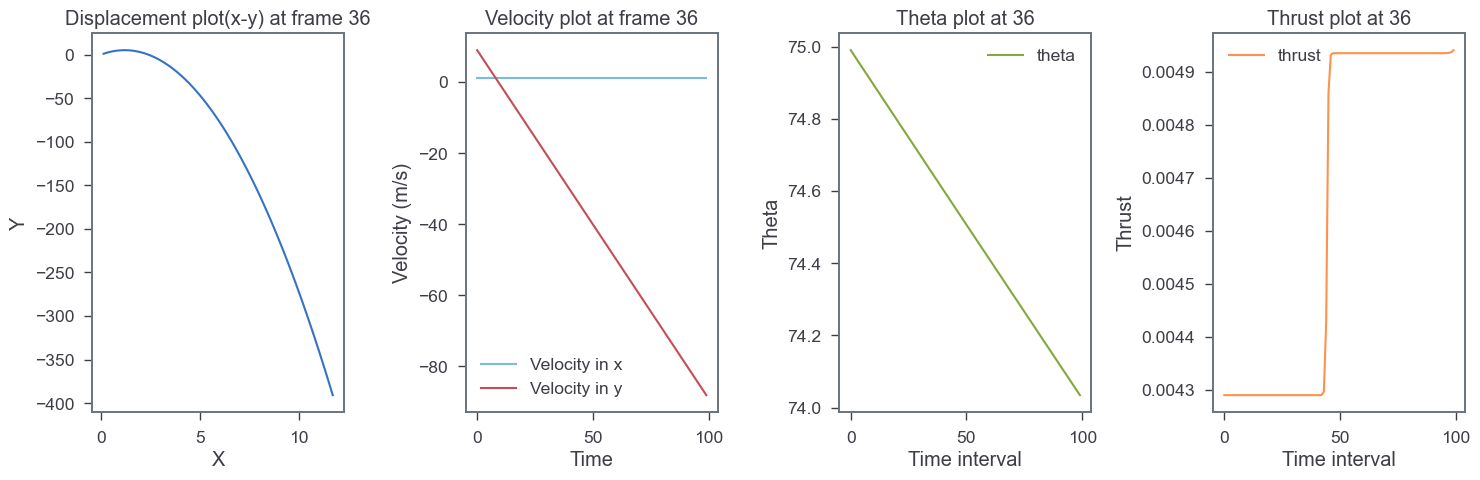

[38] loss: 33205.539


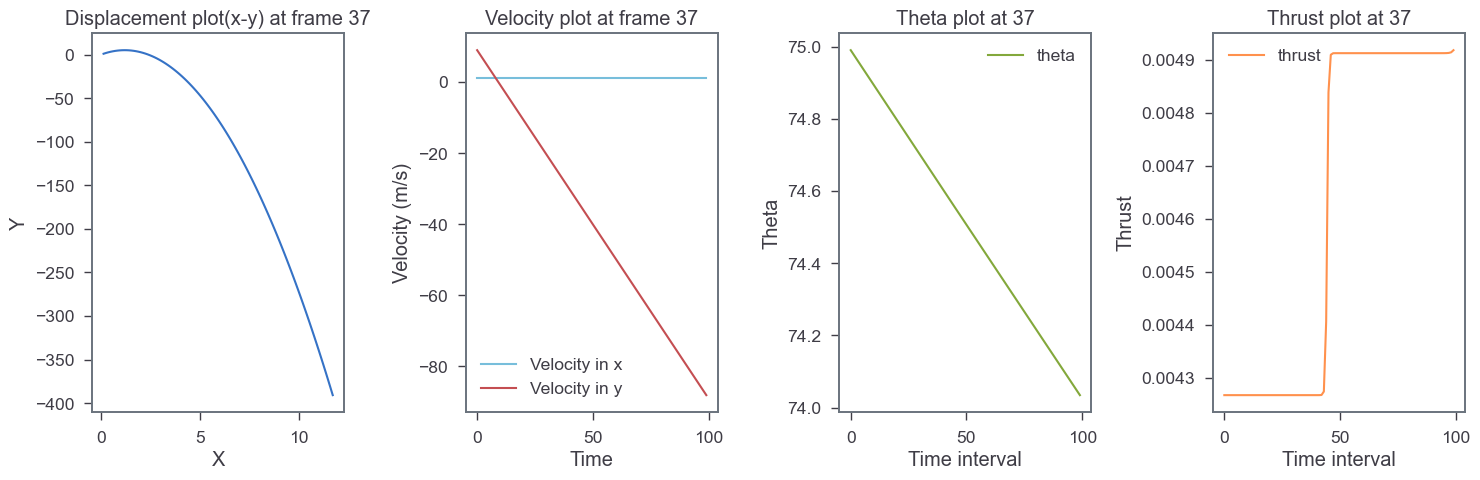

[39] loss: 33205.324


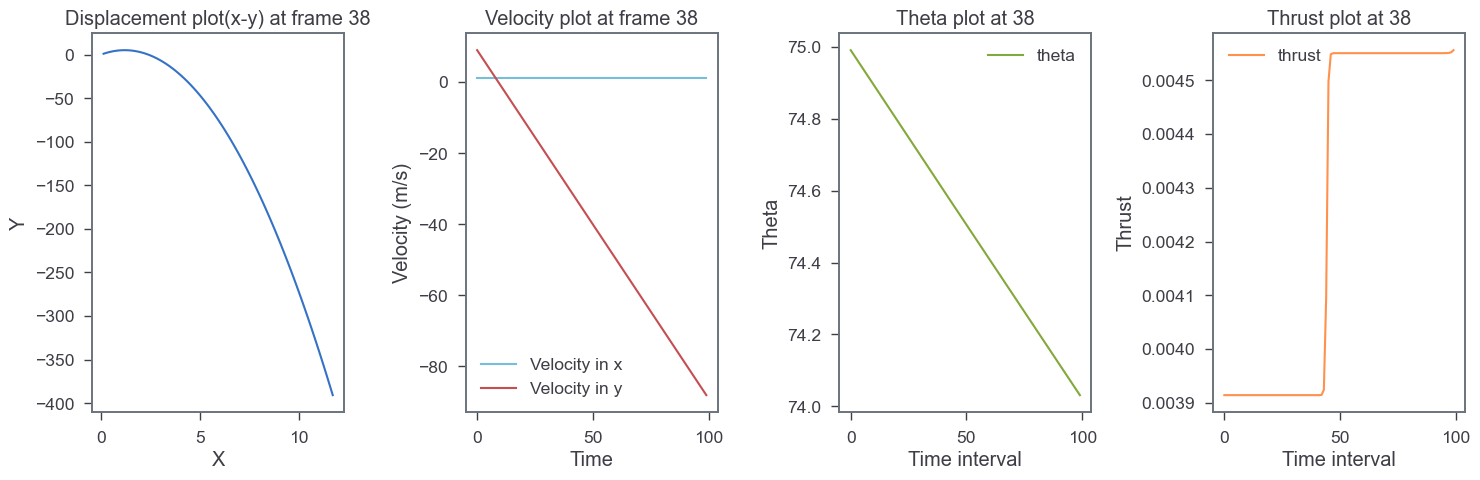

[40] loss: 33205.301


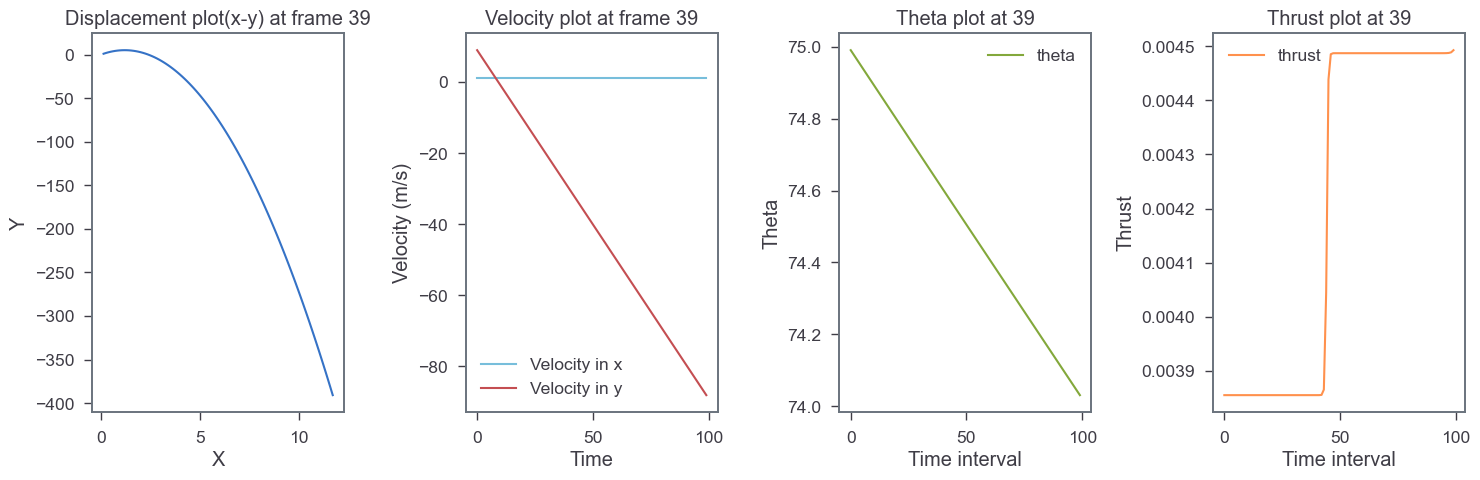

[41] loss: 33205.273


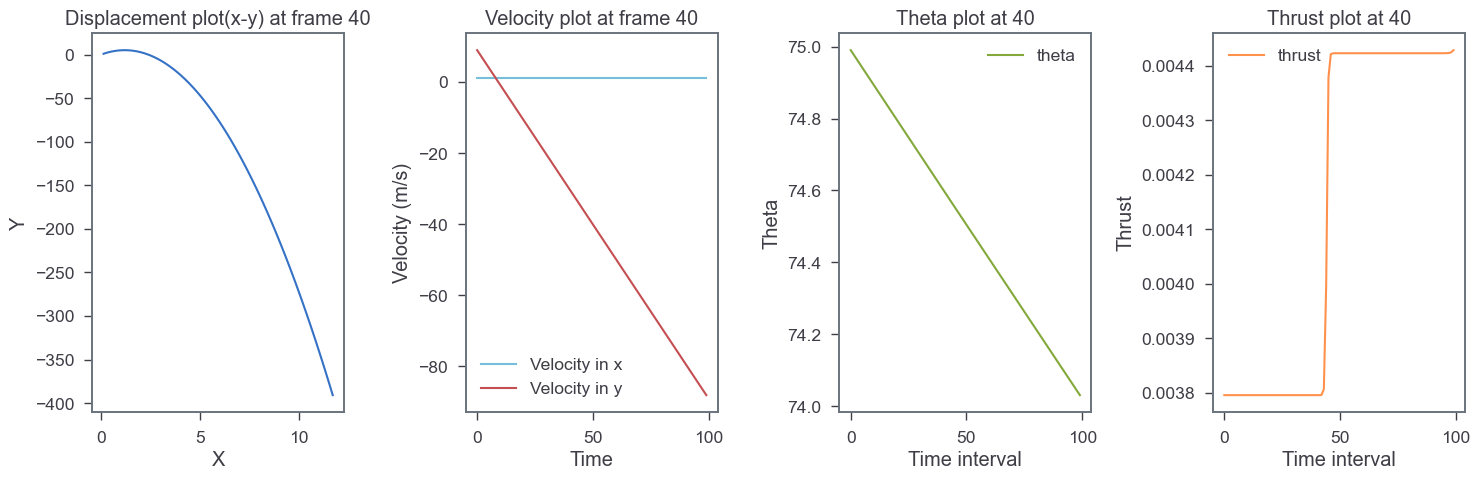

[42] loss: 33205.227


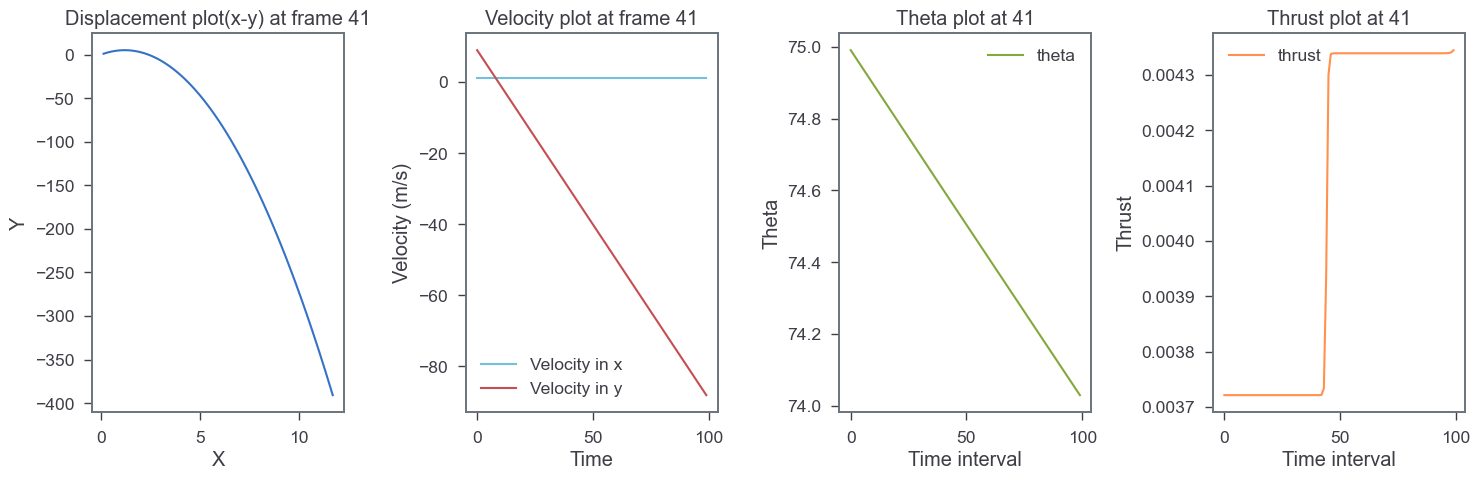

[43] loss: 33205.215


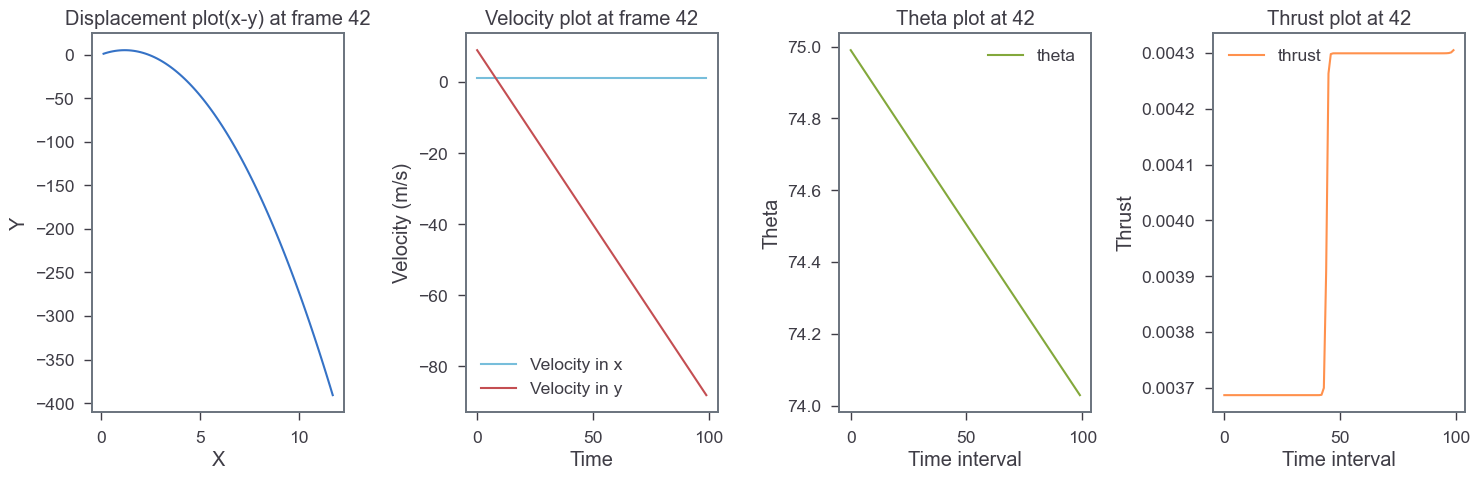

[44] loss: 33205.215


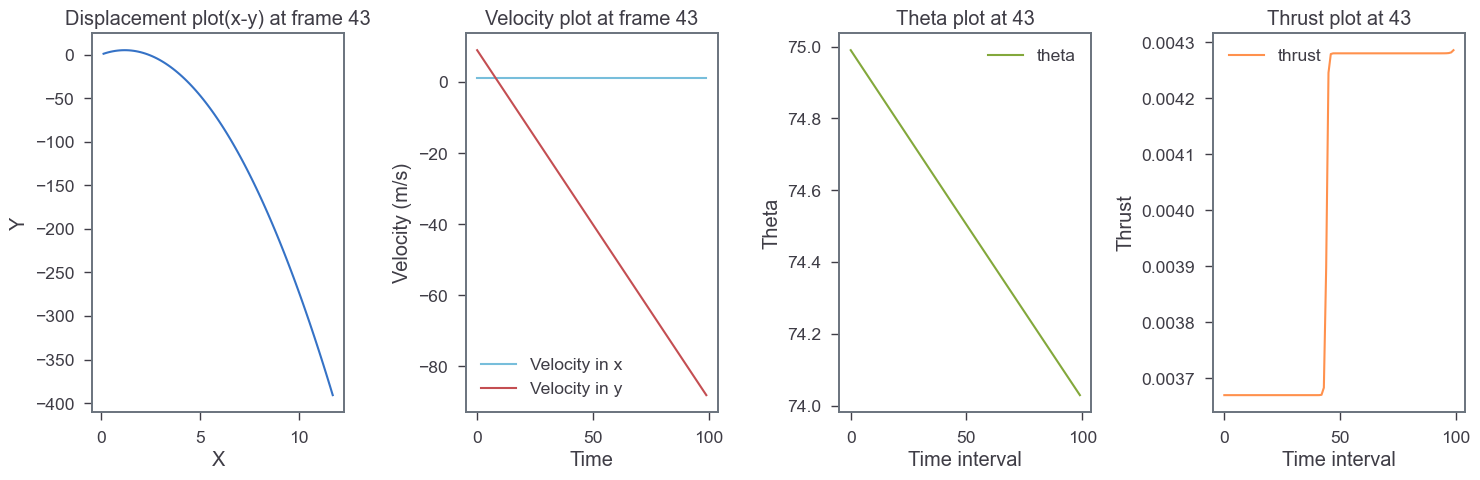

[45] loss: 33205.188


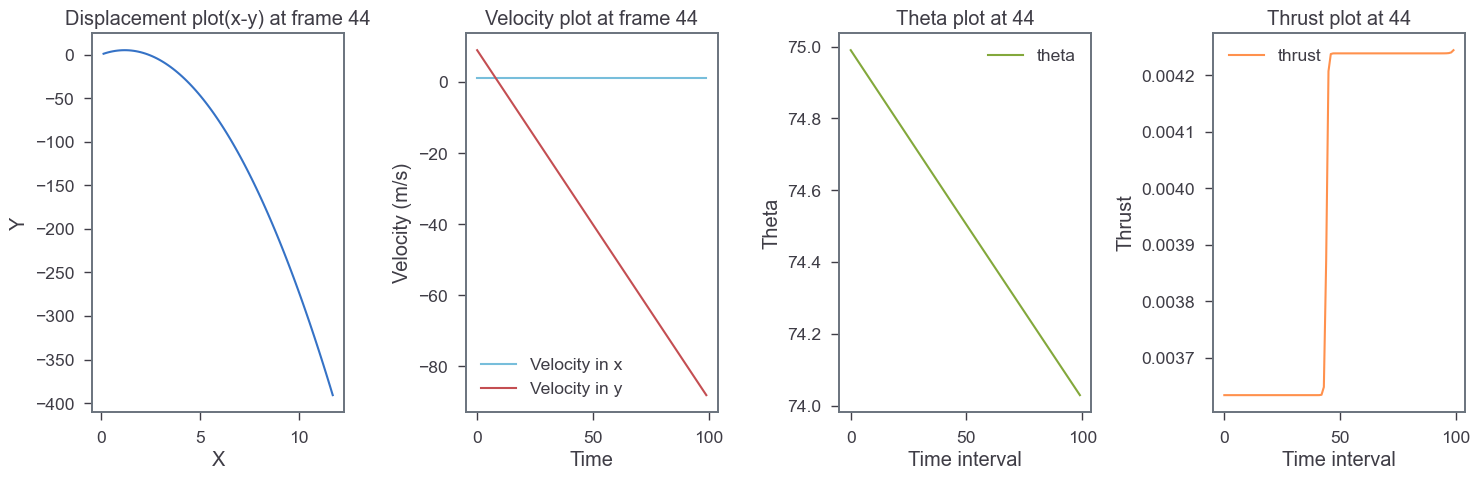

[46] loss: 33205.176


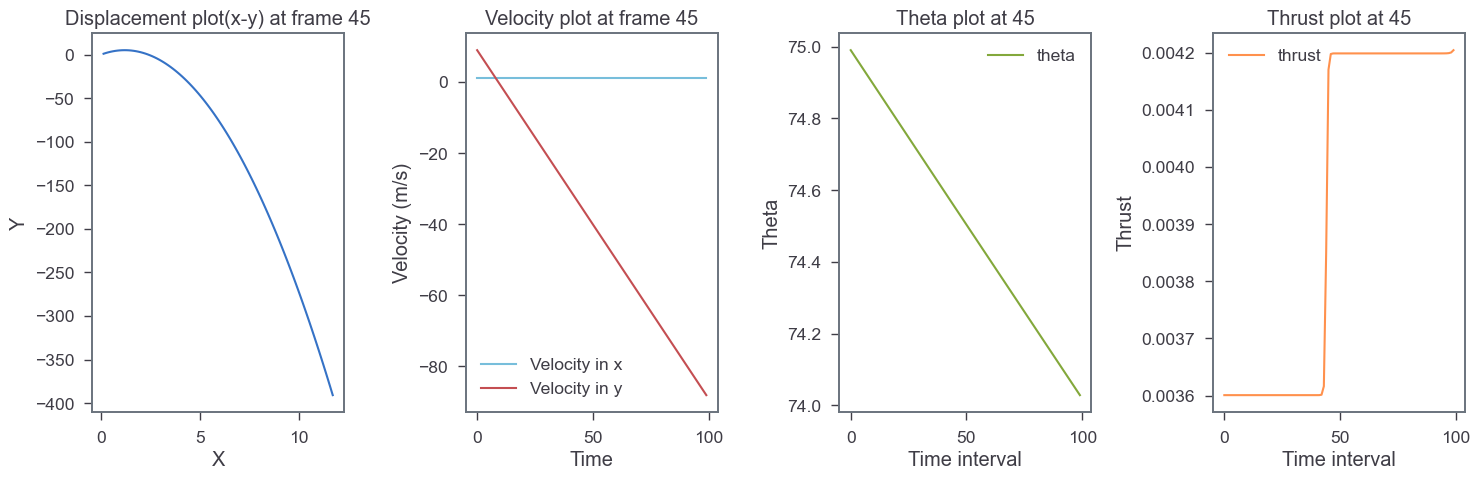

[47] loss: 33205.168


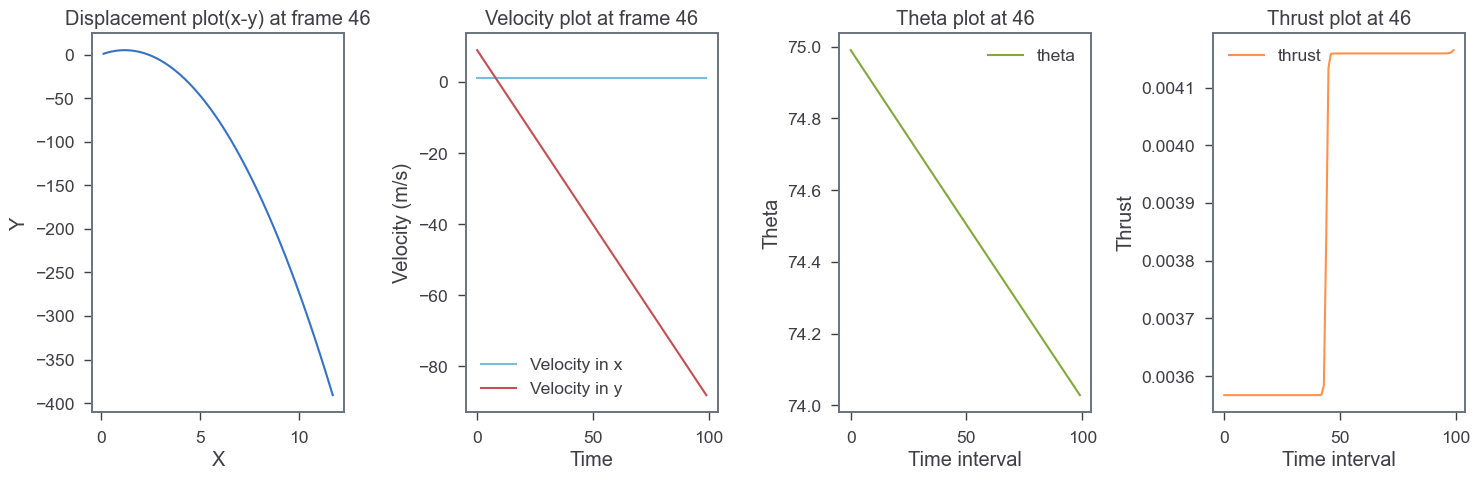

[48] loss: 33205.133


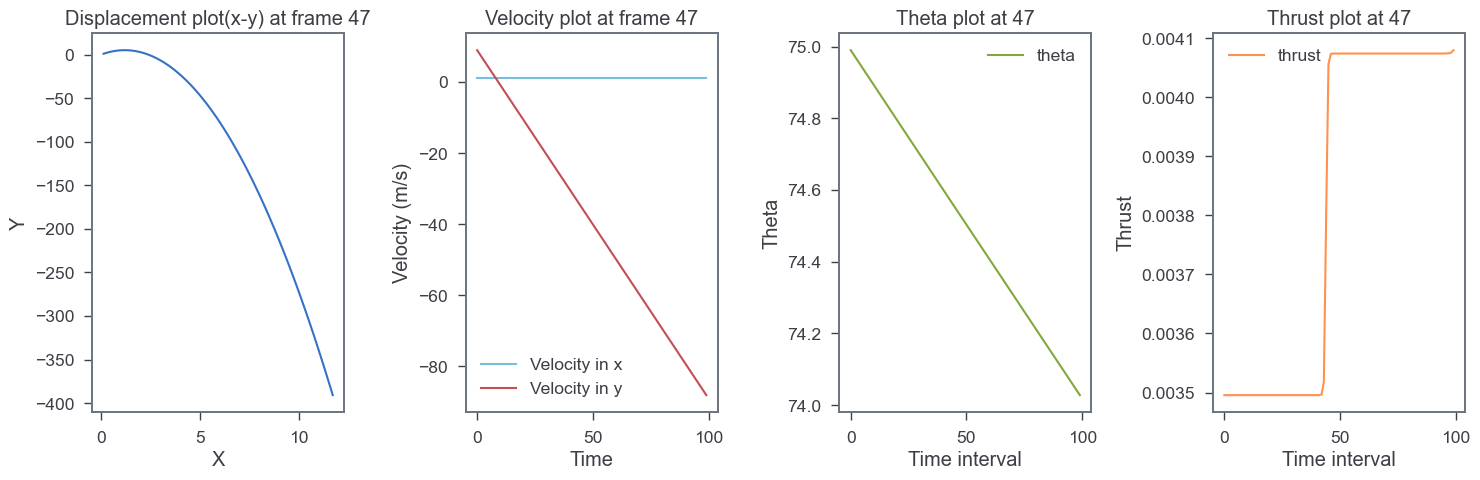

[49] loss: 33205.133


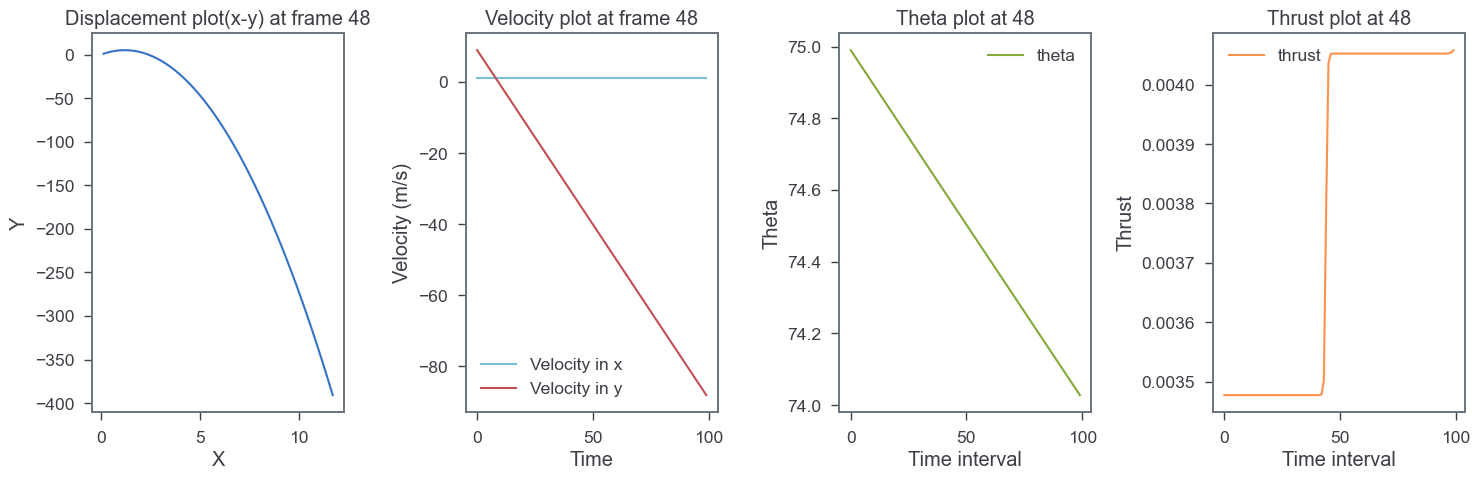

[50] loss: 33205.098


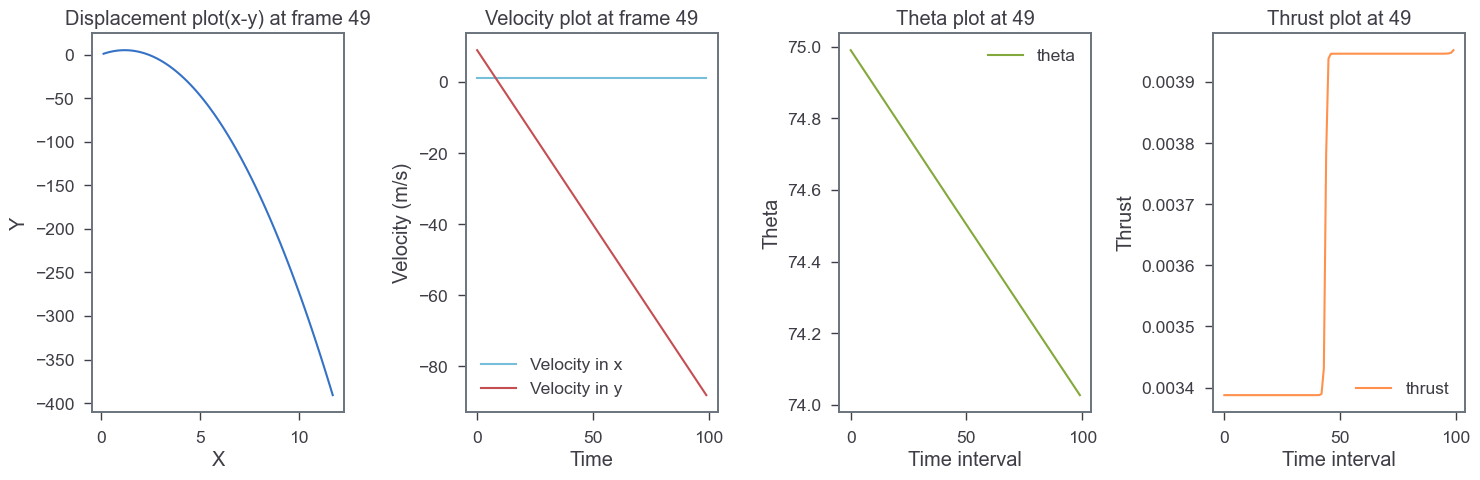

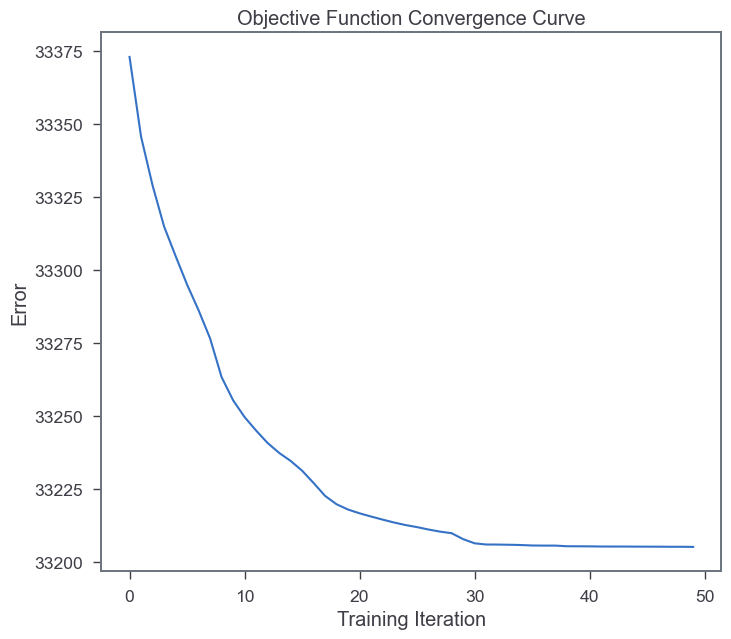

In [53]:
T = 100  # number of time steps of the simulation
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  
c = Controller(dim_input, dim_hidden, dim_output)  
s = Simulation(c, d, T)  
o = Optimize(s)  
o.train(50) 